# Make final figures
Makes final versions of figures.

## Import Python packages

In [1]:
import os
import re
import shutil
import string
import xml.etree.ElementTree as ElementTree

import cairosvg

from IPython.display import display, Image, SVG

import matplotlib.pyplot as plt
plt.ion()
import matplotlib.image

import pandas as pd

from plotnine import *

import svgutils

import yaml

from dms_tools2.ipython_utils import showPDF
from dms_tools2.plot import COLOR_BLIND_PALETTE_GRAY as PALETTE

## Define some functions

In [2]:
def svg_dim(svgfile, dim):
    """Get width or height `dim` of `svgfile` in points."""
    return float(ElementTree.parse(svgfile)
                 .getroot().attrib[dim]
                 .replace('px', '')
                 .replace('pt', ''))

In [3]:
def svg_to_pdf(svgfile):
    """`svgfile` to PDF, return converted file name."""
    with open(svgfile) as f:
        svg = f.read()
    # need to eliminate units that `svgutils` incorrectly puts in viewBox
    viewbox_match = re.compile('viewBox="' + ' '.join(['\d+\.{0,1}\d*(px){0,1}'] * 4) + '"')
    if len(viewbox_match.findall(svg)) != 1:
        raise ValueError(f"did not find exactly one viewBox in {svgfile}")
    viewbox = viewbox_match.search(svg).group(0)
    svg = svg.replace(viewbox, viewbox.replace('px', ''))
    outfile = os.path.splitext(svgfile)[0] + '.pdf'
    cairosvg.svg2pdf(bytestring=svg, write_to=outfile)
    return outfile

In [4]:
def png_aspect(pngfile):
    """Aspect ratio (width to height) of `pngfile`."""
    shape = matplotlib.image.imread(pngfile).shape
    return shape[1] / shape[0]

## Read configuration

In [5]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)
    
with open(config['figure_config']) as f:
    figure_config = yaml.safe_load(f)
    
os.makedirs(config['finalfigsdir'], exist_ok=True)
print(f"Final figures go in {config['finalfigsdir']}")

Final figures go in results/figures/final


## Define antibody samples
Some of the figure making processes differ for the antibody and non-antibody samples.
Here are the antibody ones:

In [6]:
antibodies = ['antibody_region_B', 'antibody_lower_head']

## Make combined logo / neut / struct plots

First for **non**-antibody samples:


Writing figure for VIDD_sera to results/figures/final/VIDD_sera.pdf


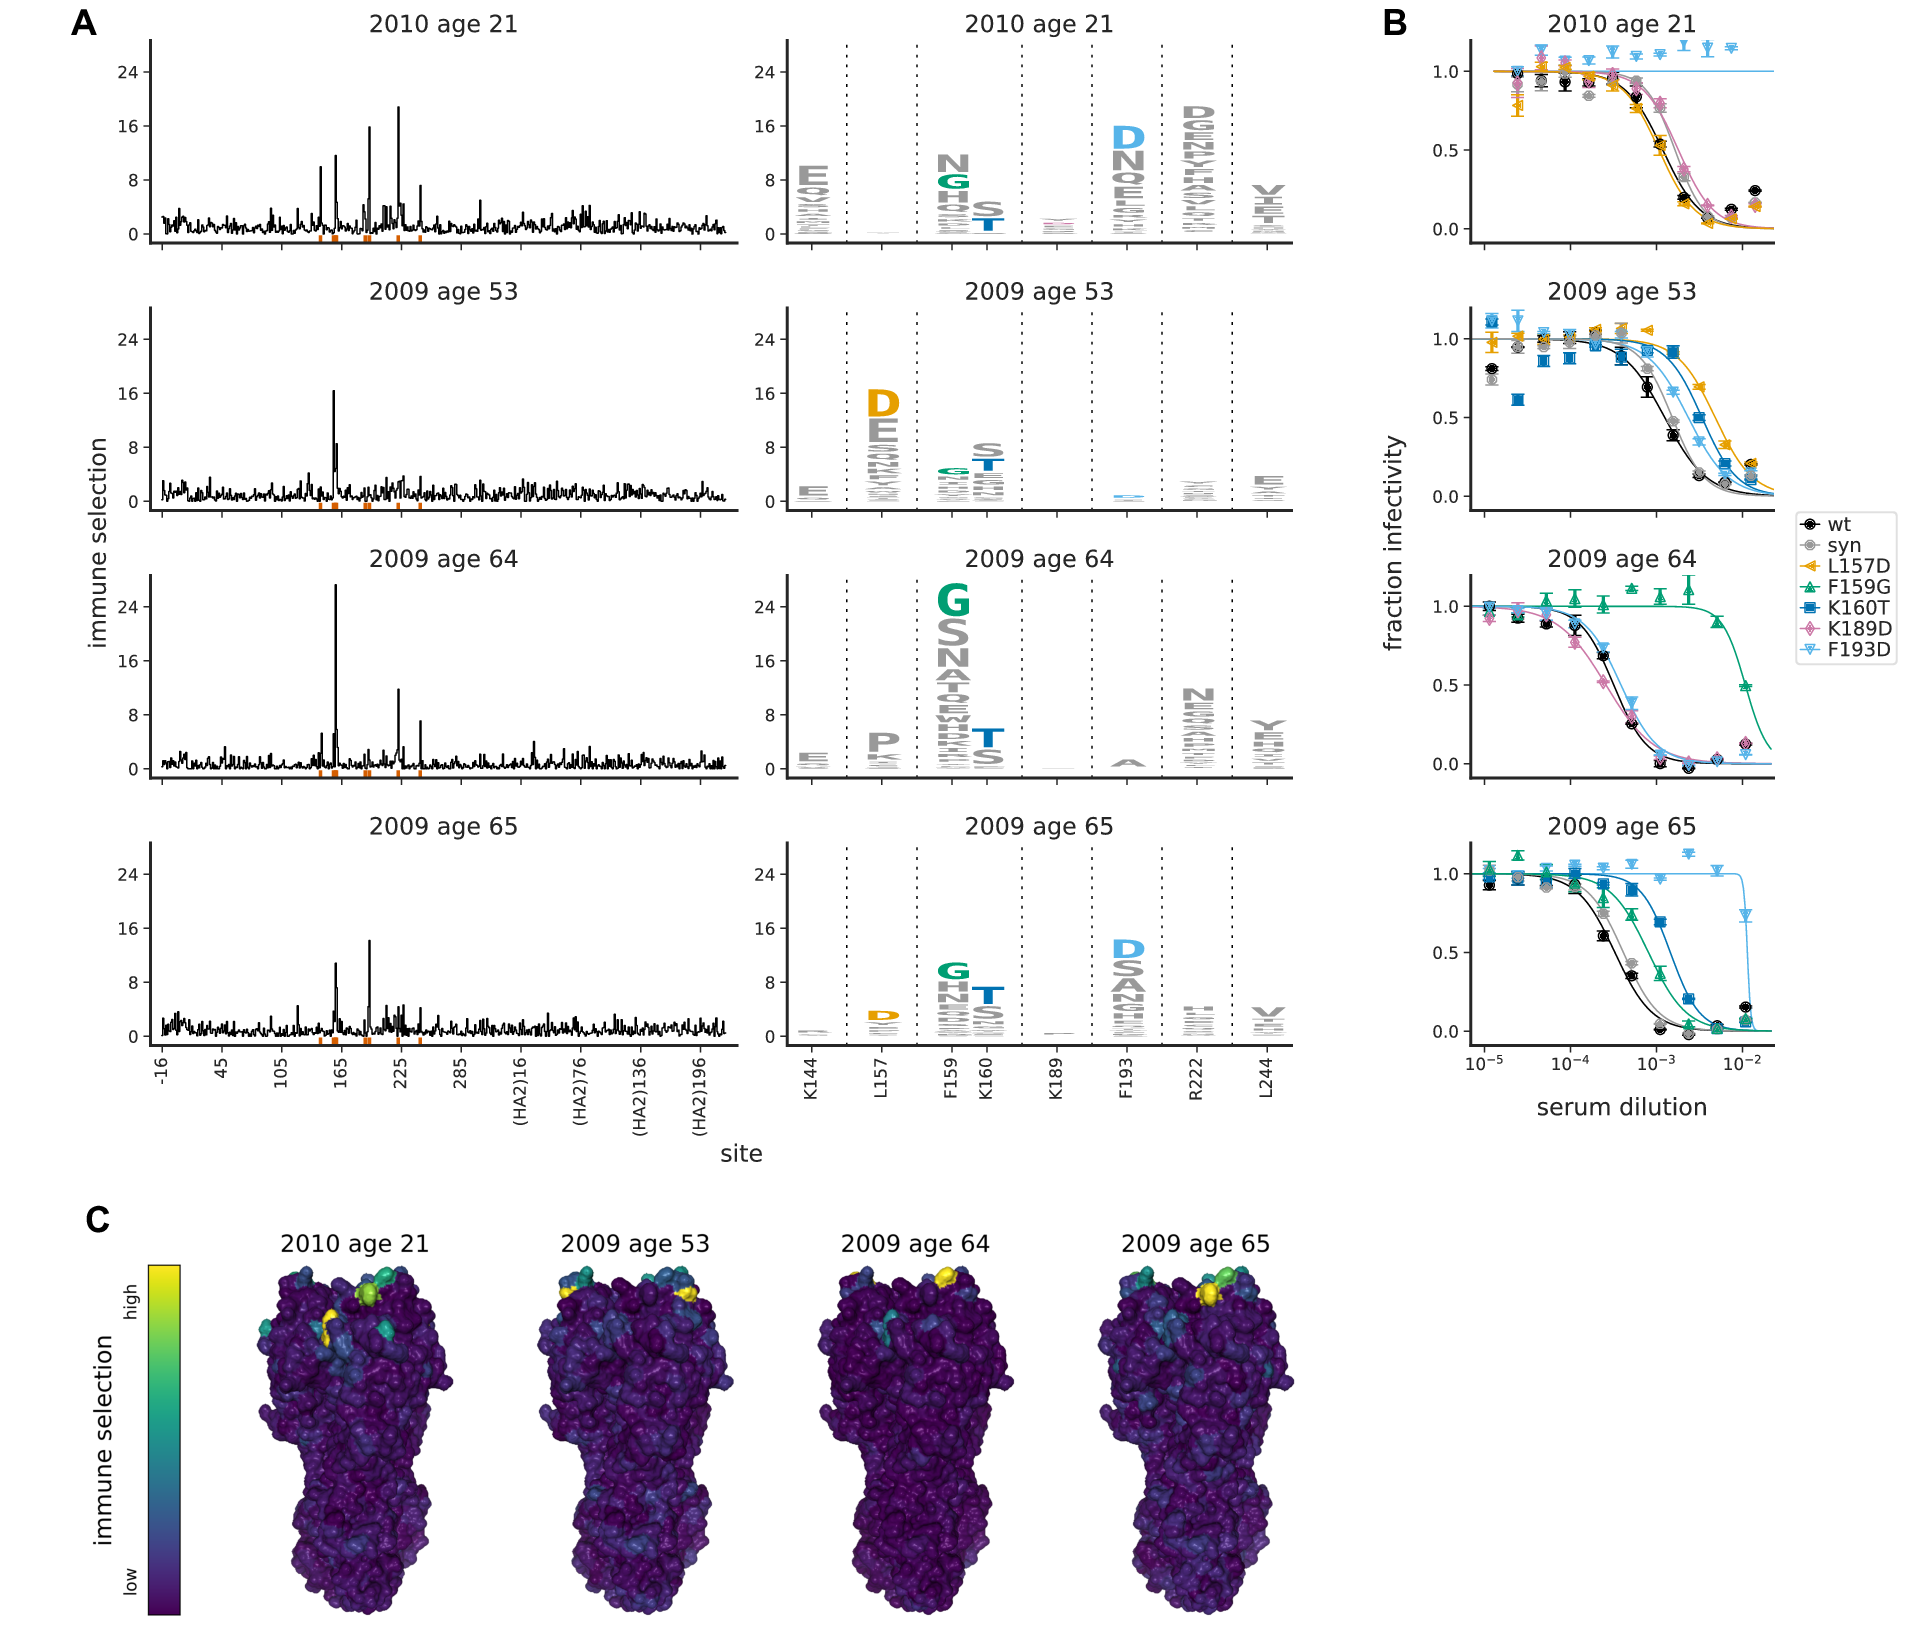


Writing figure for 2009_age_53_samples to results/figures/final/2009_age_53_samples.pdf


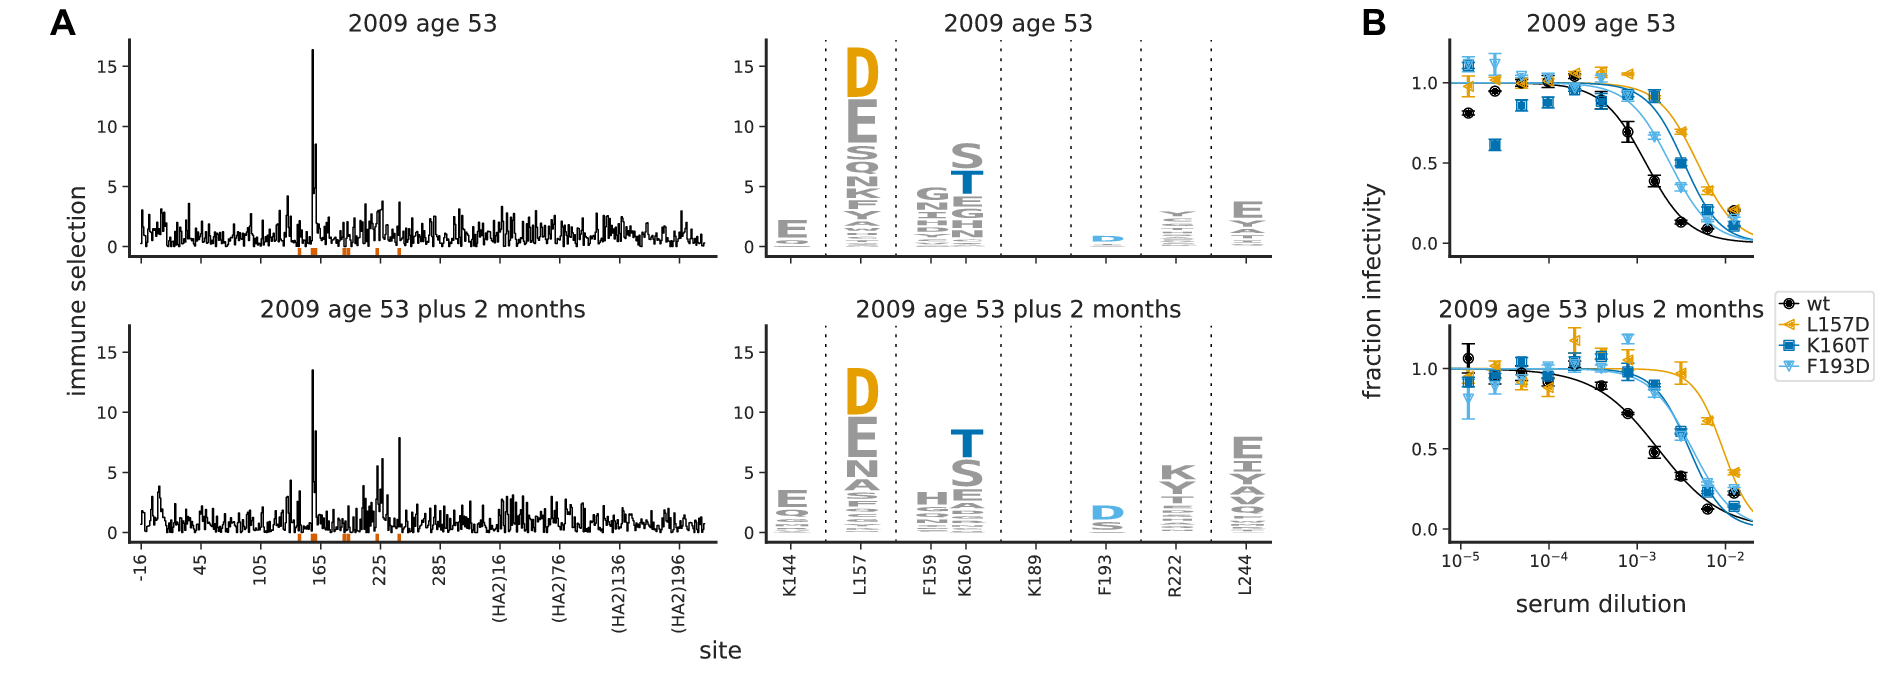


Writing figure for Hensley_sera to results/figures/final/Hensley_sera.pdf


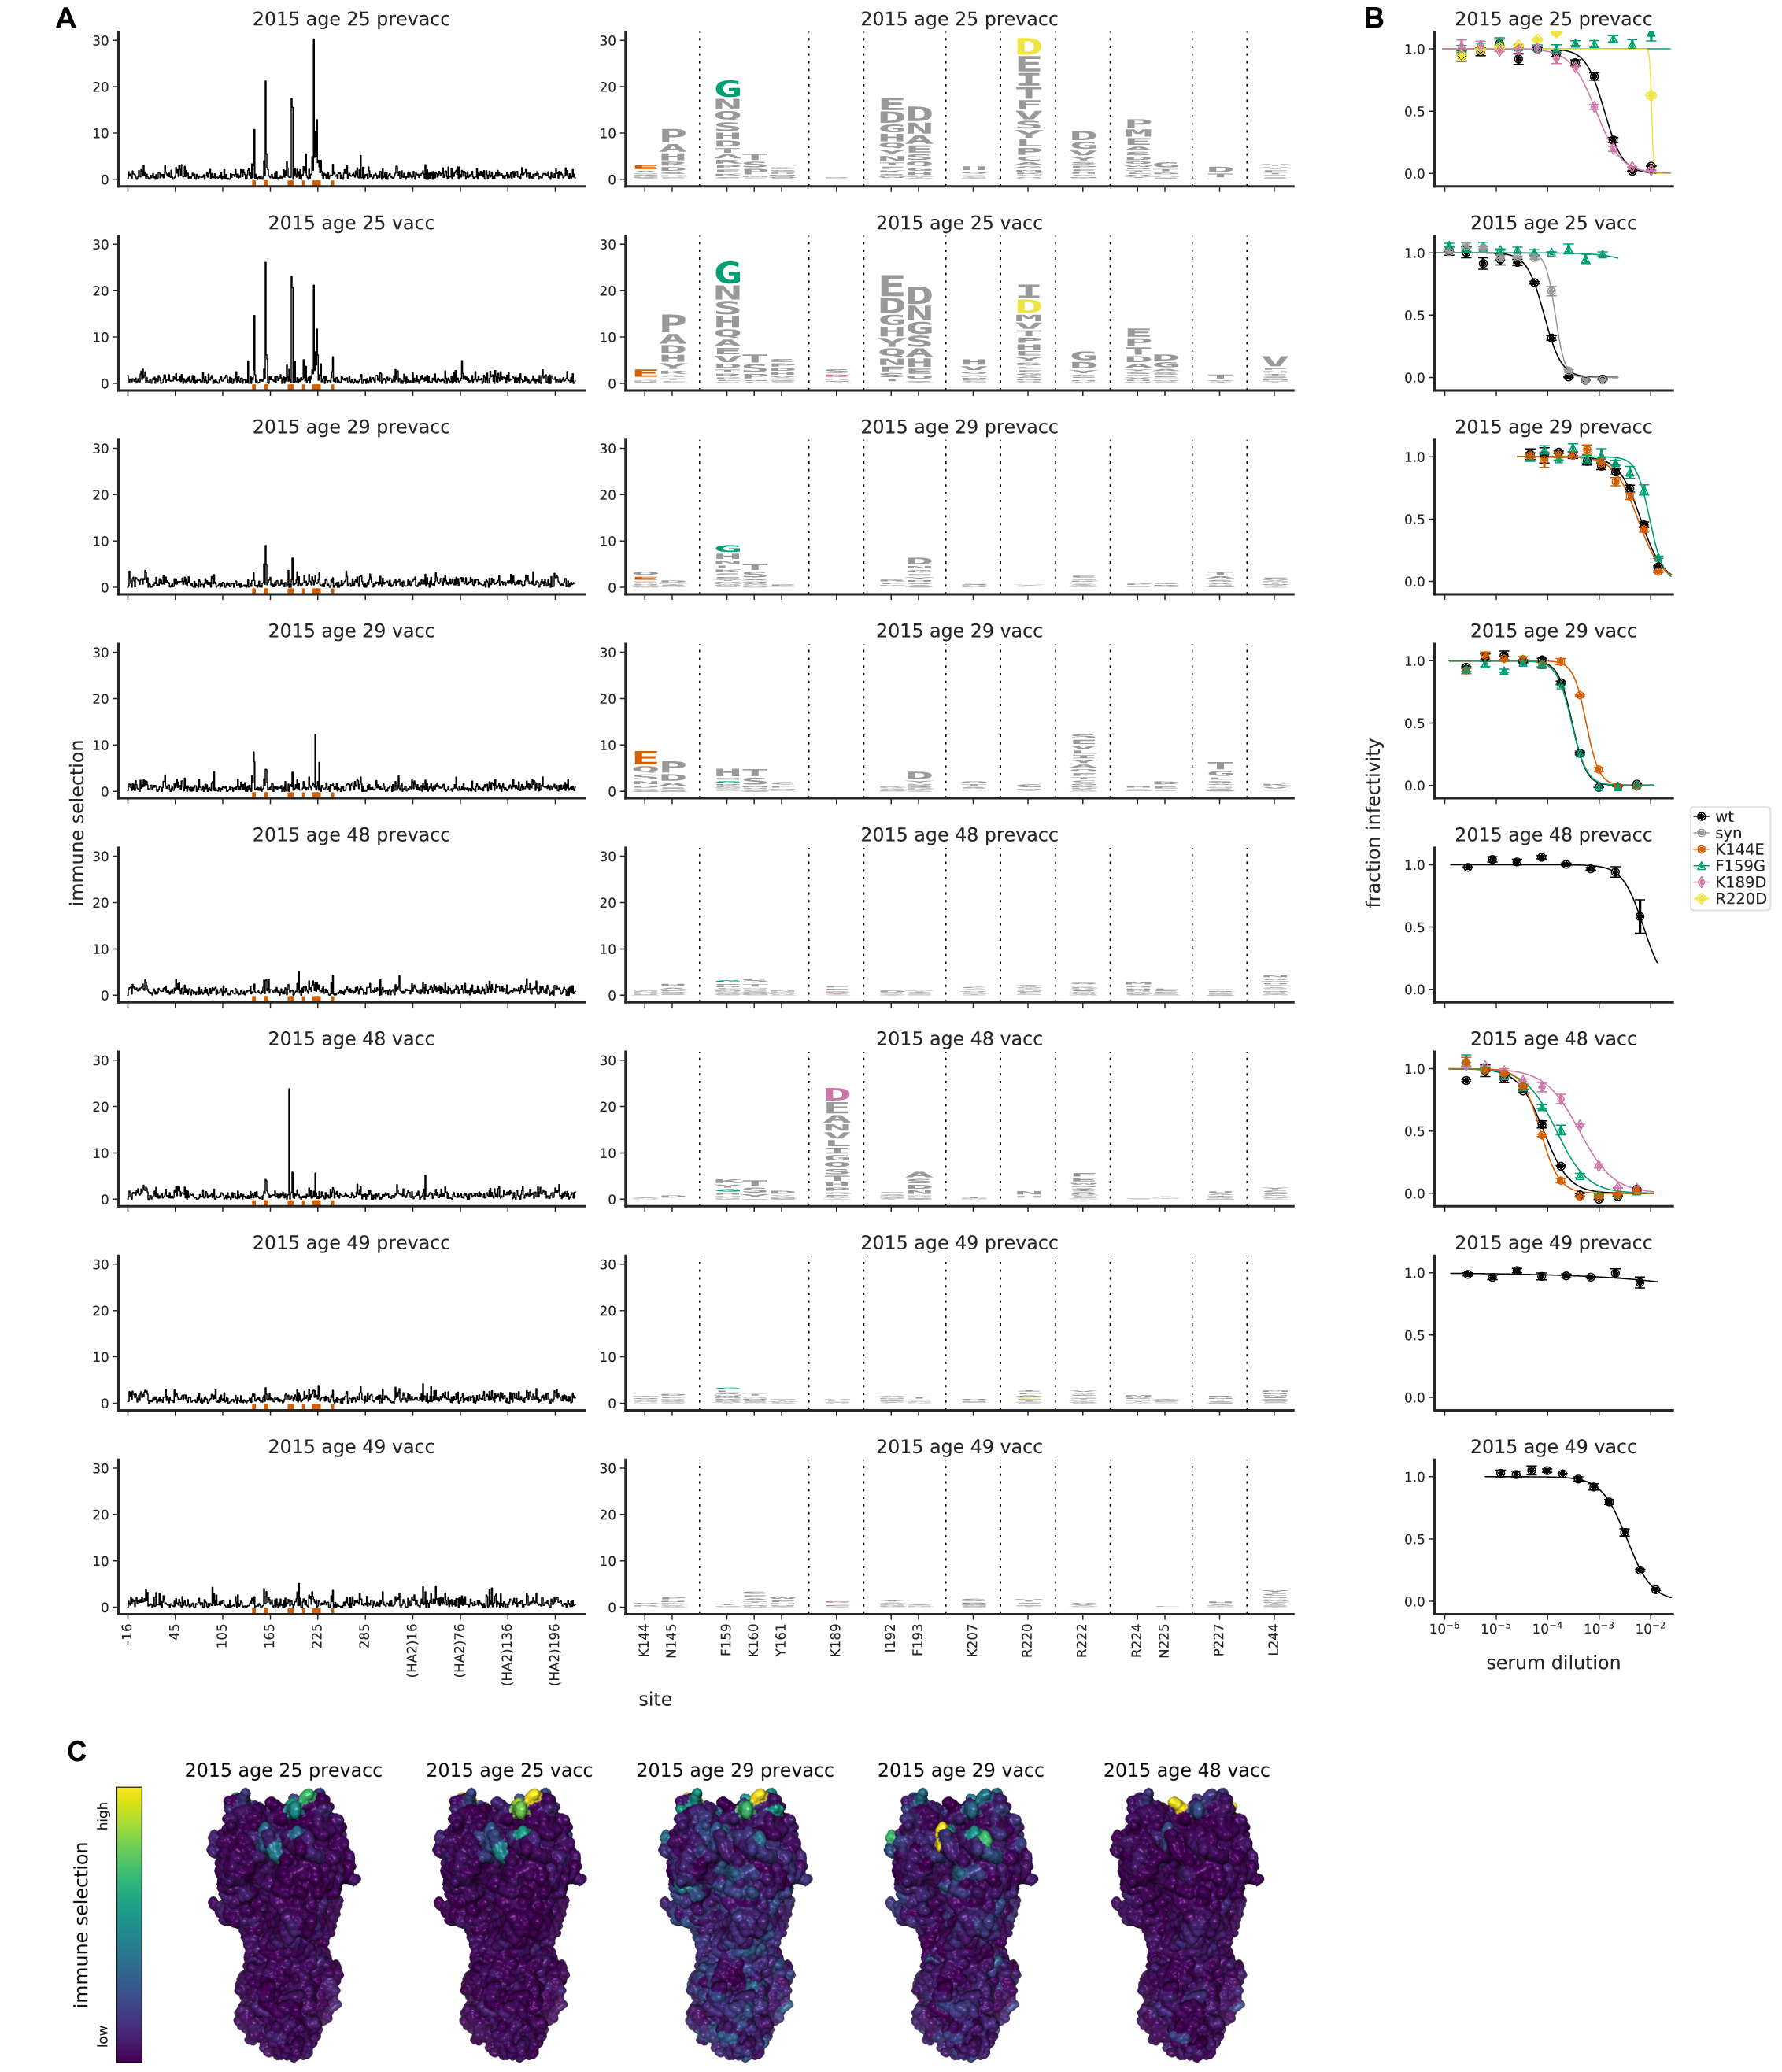


Writing figure for ferret to results/figures/final/ferret.pdf


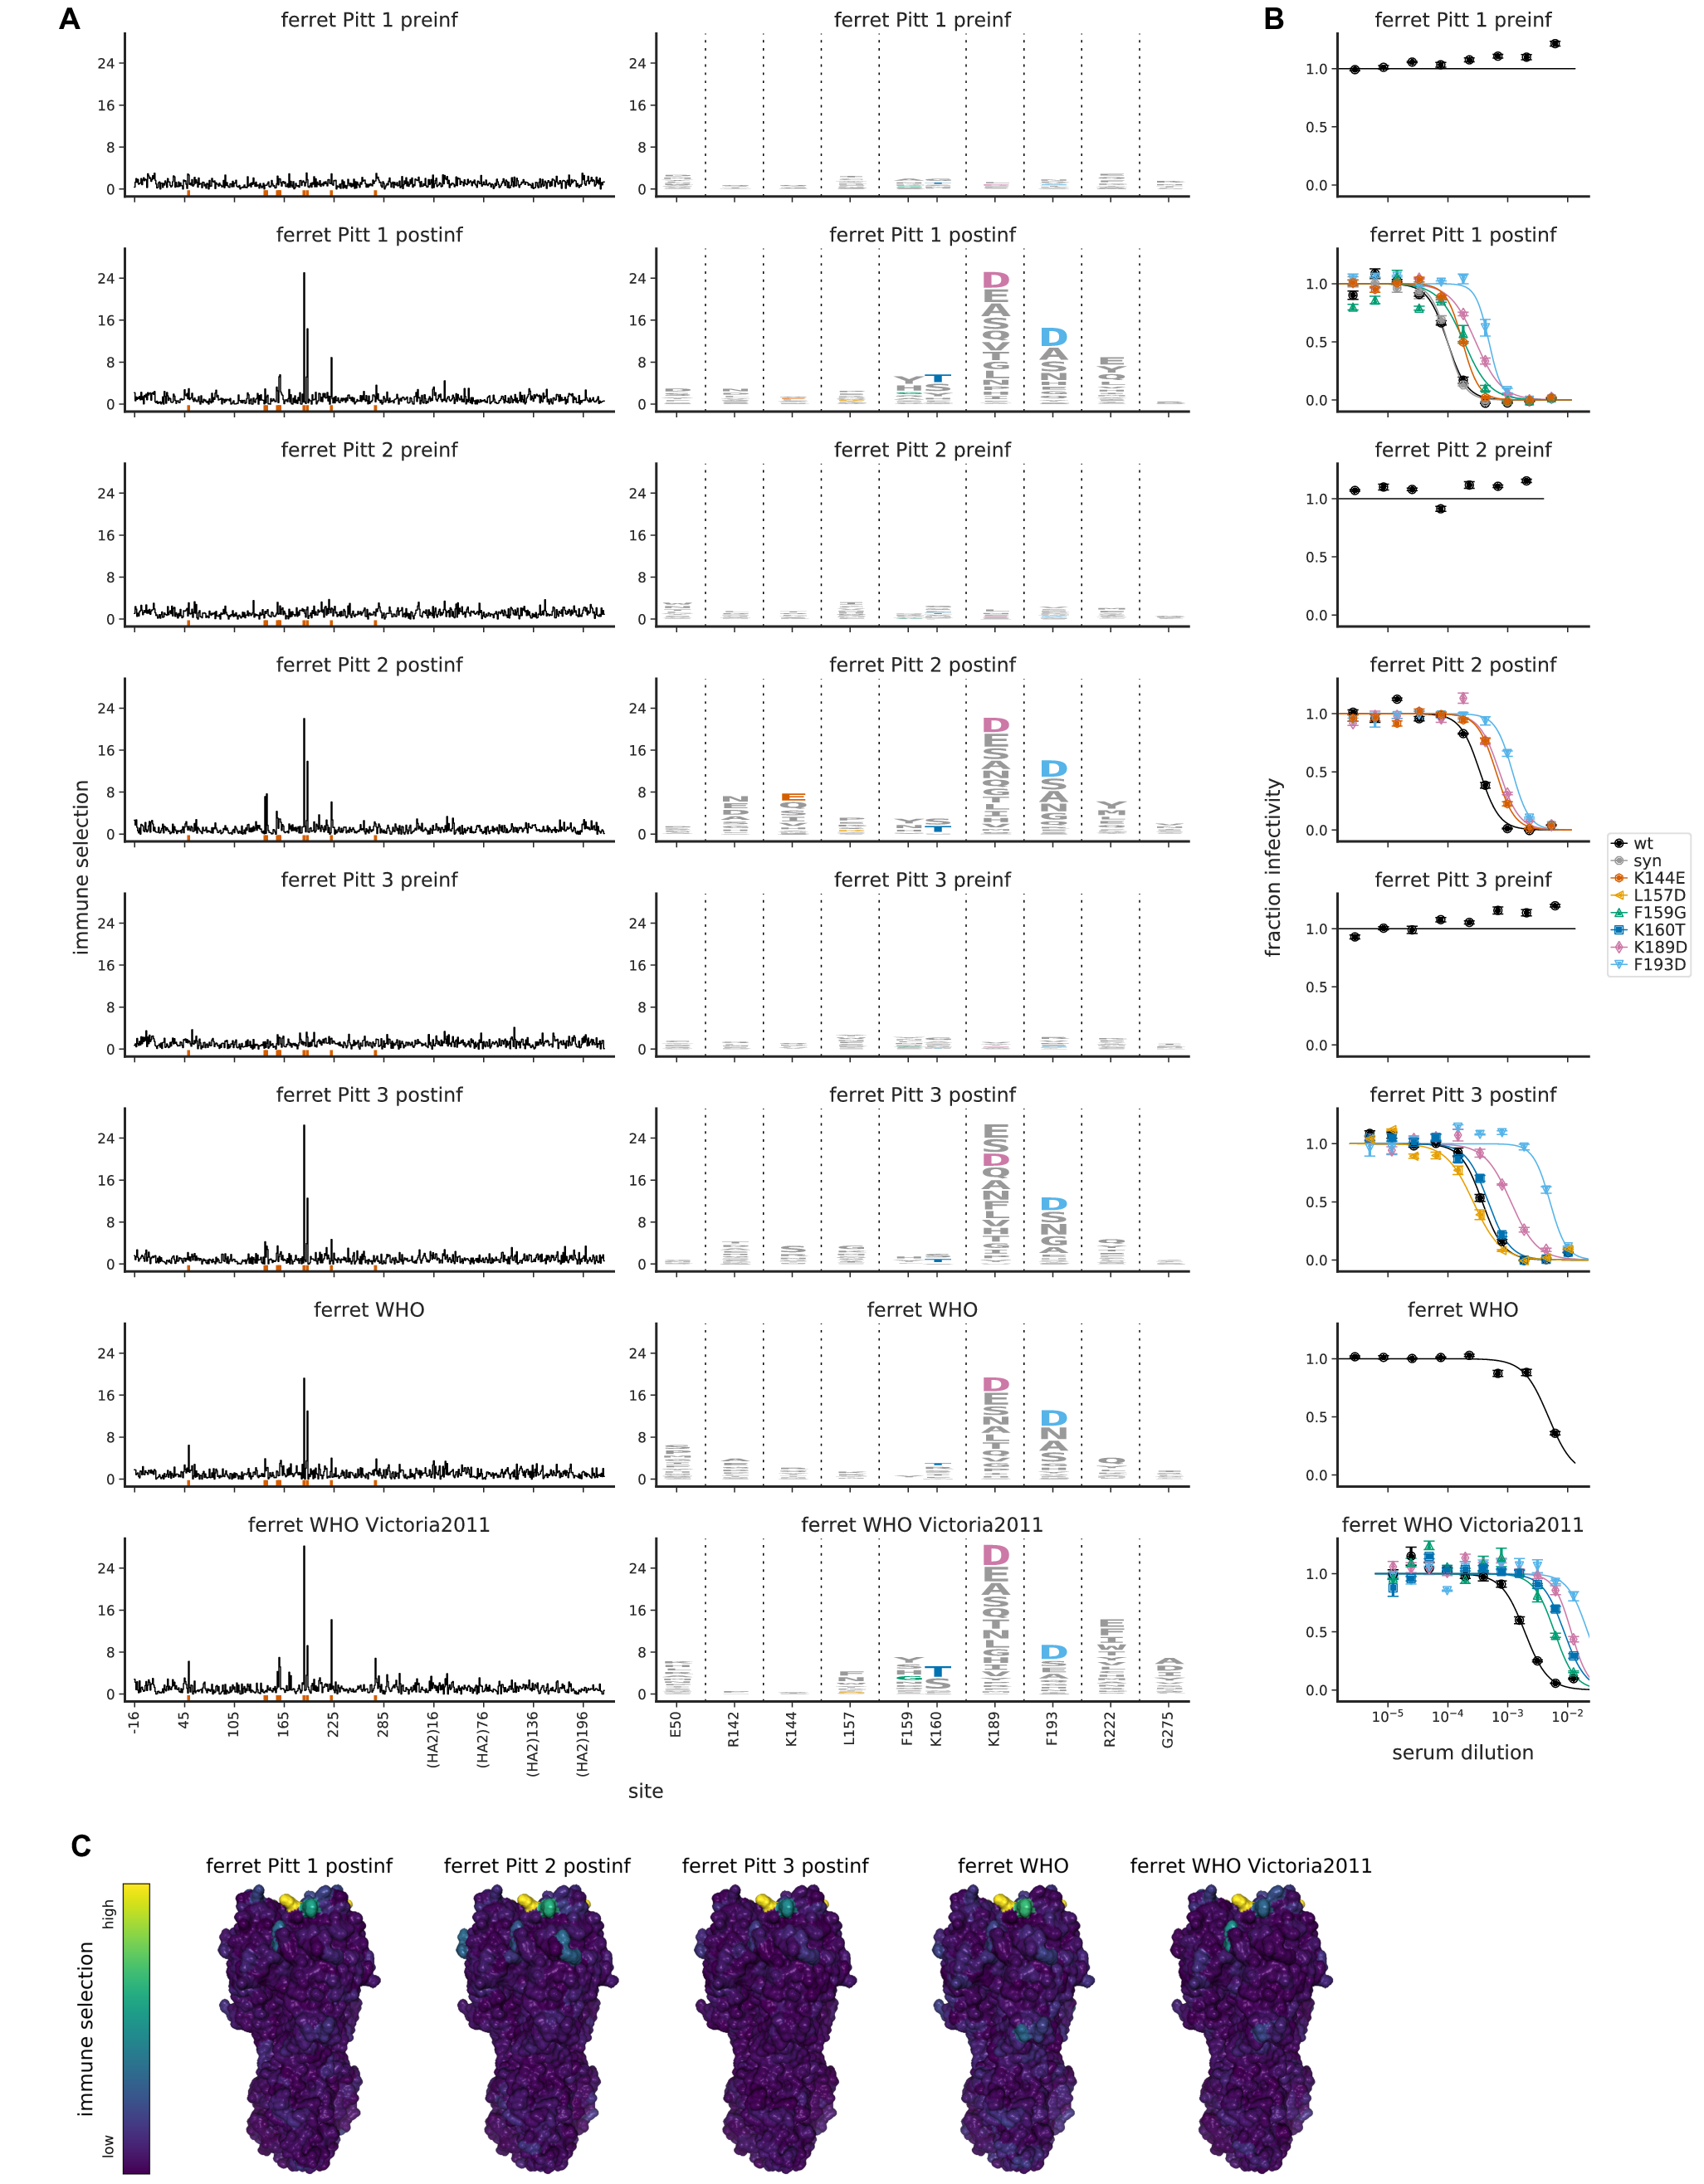


Writing figure for antibody_spikein to results/figures/final/antibody_spikein.pdf


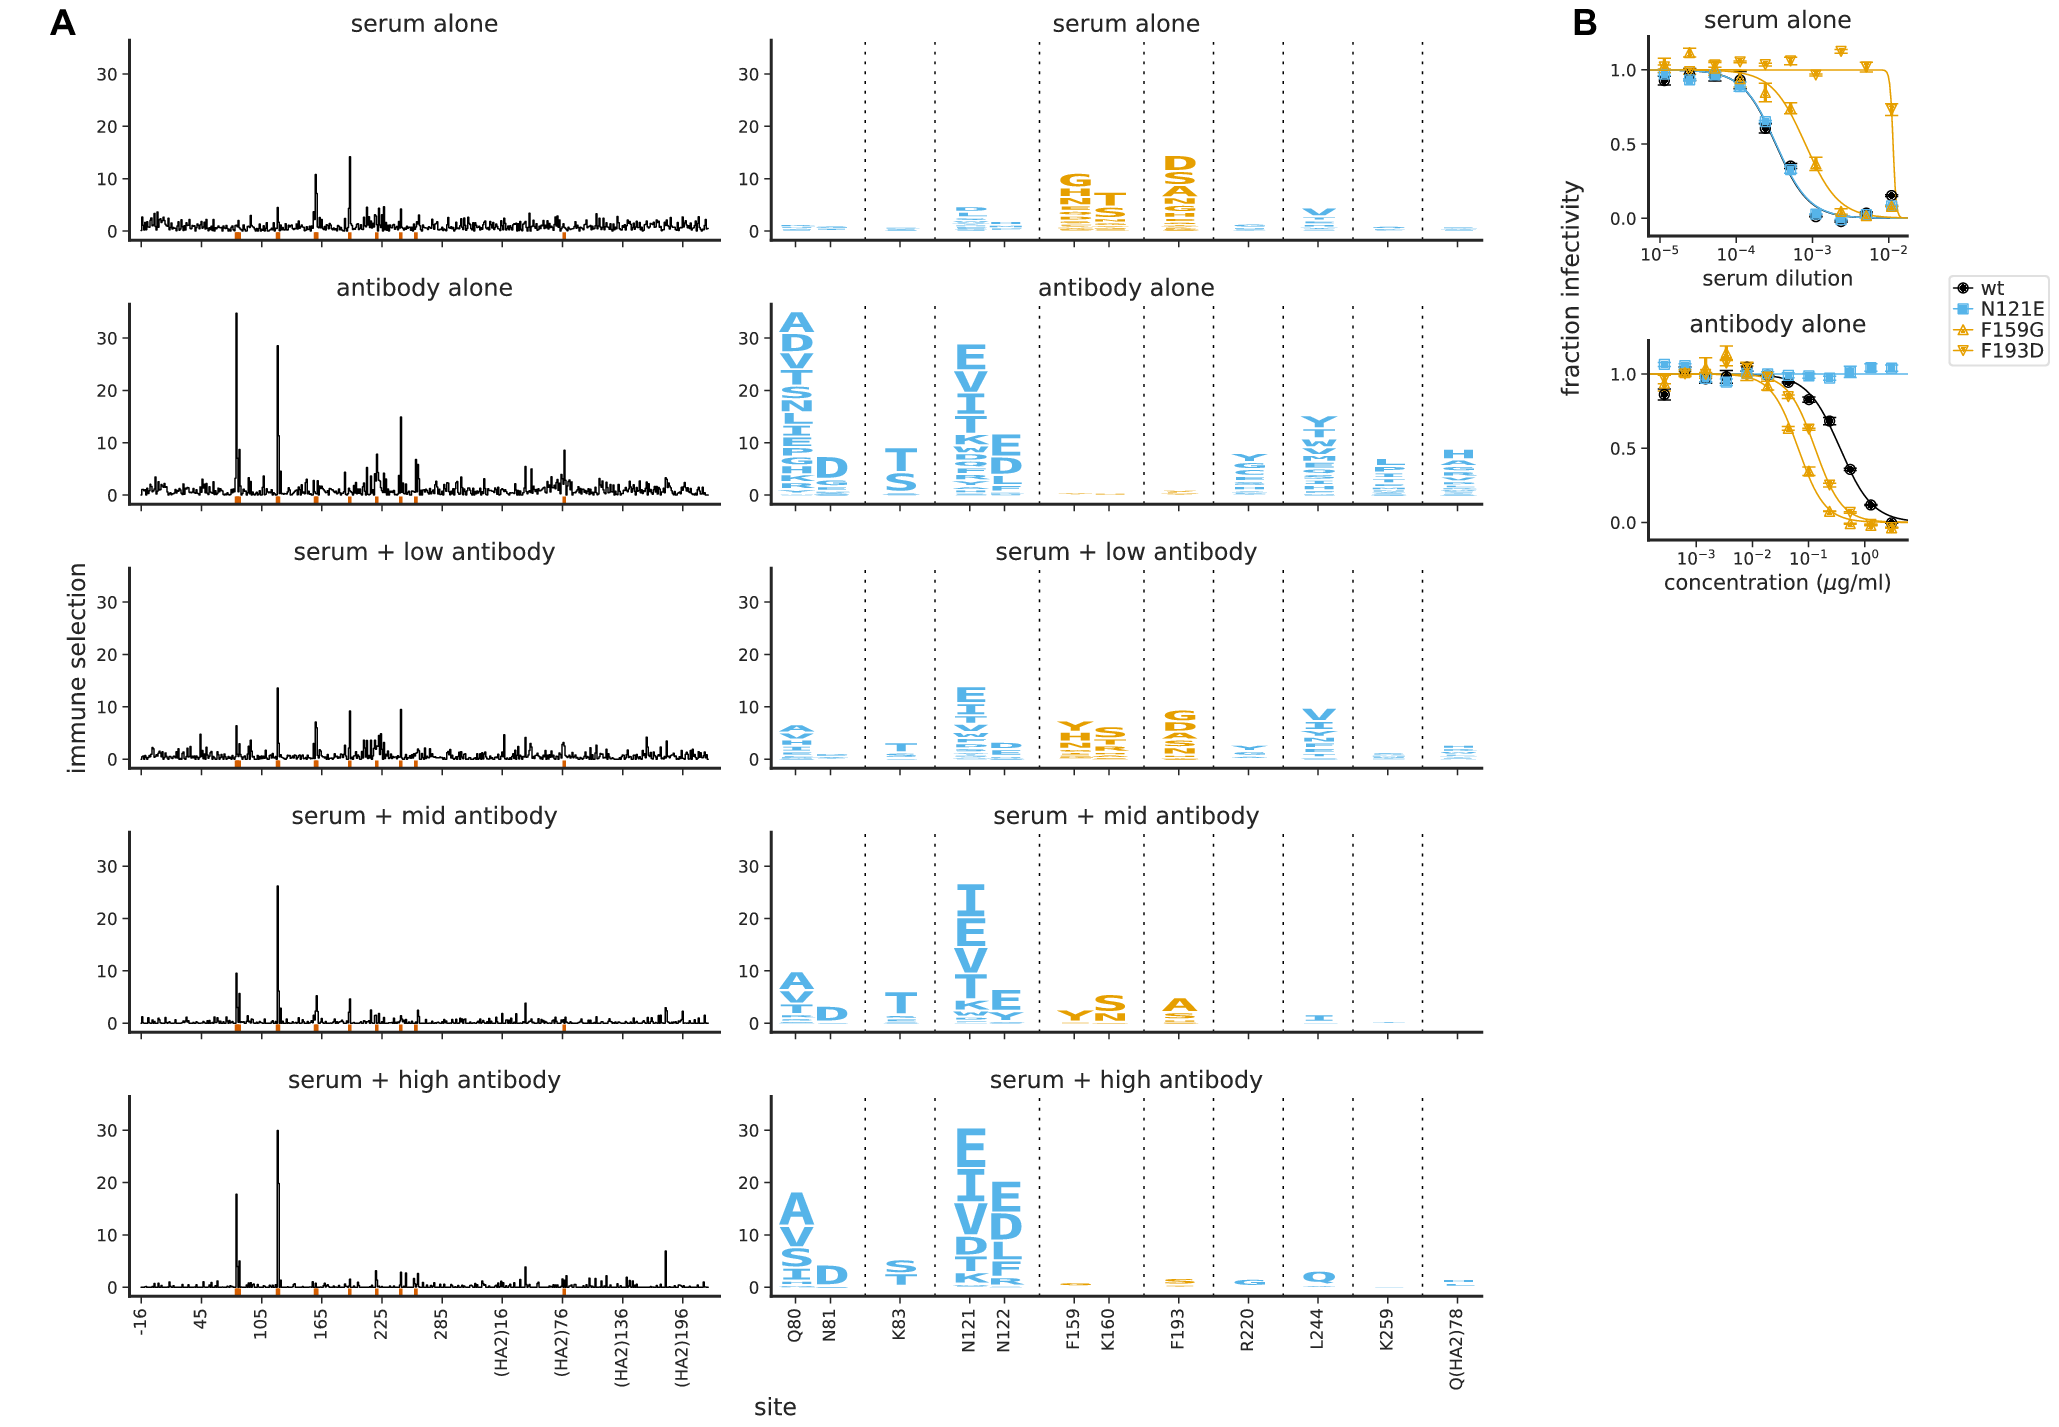

In [7]:
vmargin = 35  # vertical space between panels
struct_relheight = figure_config['struct_panel_height']

for fig, figconfig in figure_config['figures'].items():
    
    if fig in antibodies:
        continue
    
    logo_and_neut_svg = os.path.join(config['figsdir'], f"{fig}_logo_and_neut.svg")
    width = svg_dim(logo_and_neut_svg, 'width')
    height = svg_dim(logo_and_neut_svg, 'height')
    
    # a relative height for logo_and_neut
    logo_and_neut_relheight = 2.5 * len(figconfig['sera']) + 0.4 + 1.3
    
    fig_elements = [svgutils.compose.SVG(logo_and_neut_svg)]
    if 'sera_for_struct' in figconfig and len(figconfig['sera_for_struct']) > 0:
        struct_png = os.path.join(config['figsdir'], f"{fig}_struct.png")
        png_height = height * struct_relheight / logo_and_neut_relheight
        height += png_height + vmargin
        fig_elements.append(svgutils.compose.Image(
                        png_aspect(struct_png) * png_height,
                        png_height,
                        struct_png).move(10, height - png_height))
        fig_elements.append(svgutils.compose.Text(figconfig['struct_panel_label'],
                                                  15, 5, weight='bold', size='26',
                                                  font='Arial').move(10, height - png_height))
    f = svgutils.compose.Figure(width, height, *fig_elements)
    svg = os.path.join(config['finalfigsdir'], f"{fig}.svg")
    f.save(svg)
    pdf = svg_to_pdf(svg)
    print(f"\nWriting figure for {fig} to {pdf}")
    showPDF(pdf)

Now for antibody samples, combined into one figure:


Writing figure for antibodies to results/figures/final/antibodies.pdf


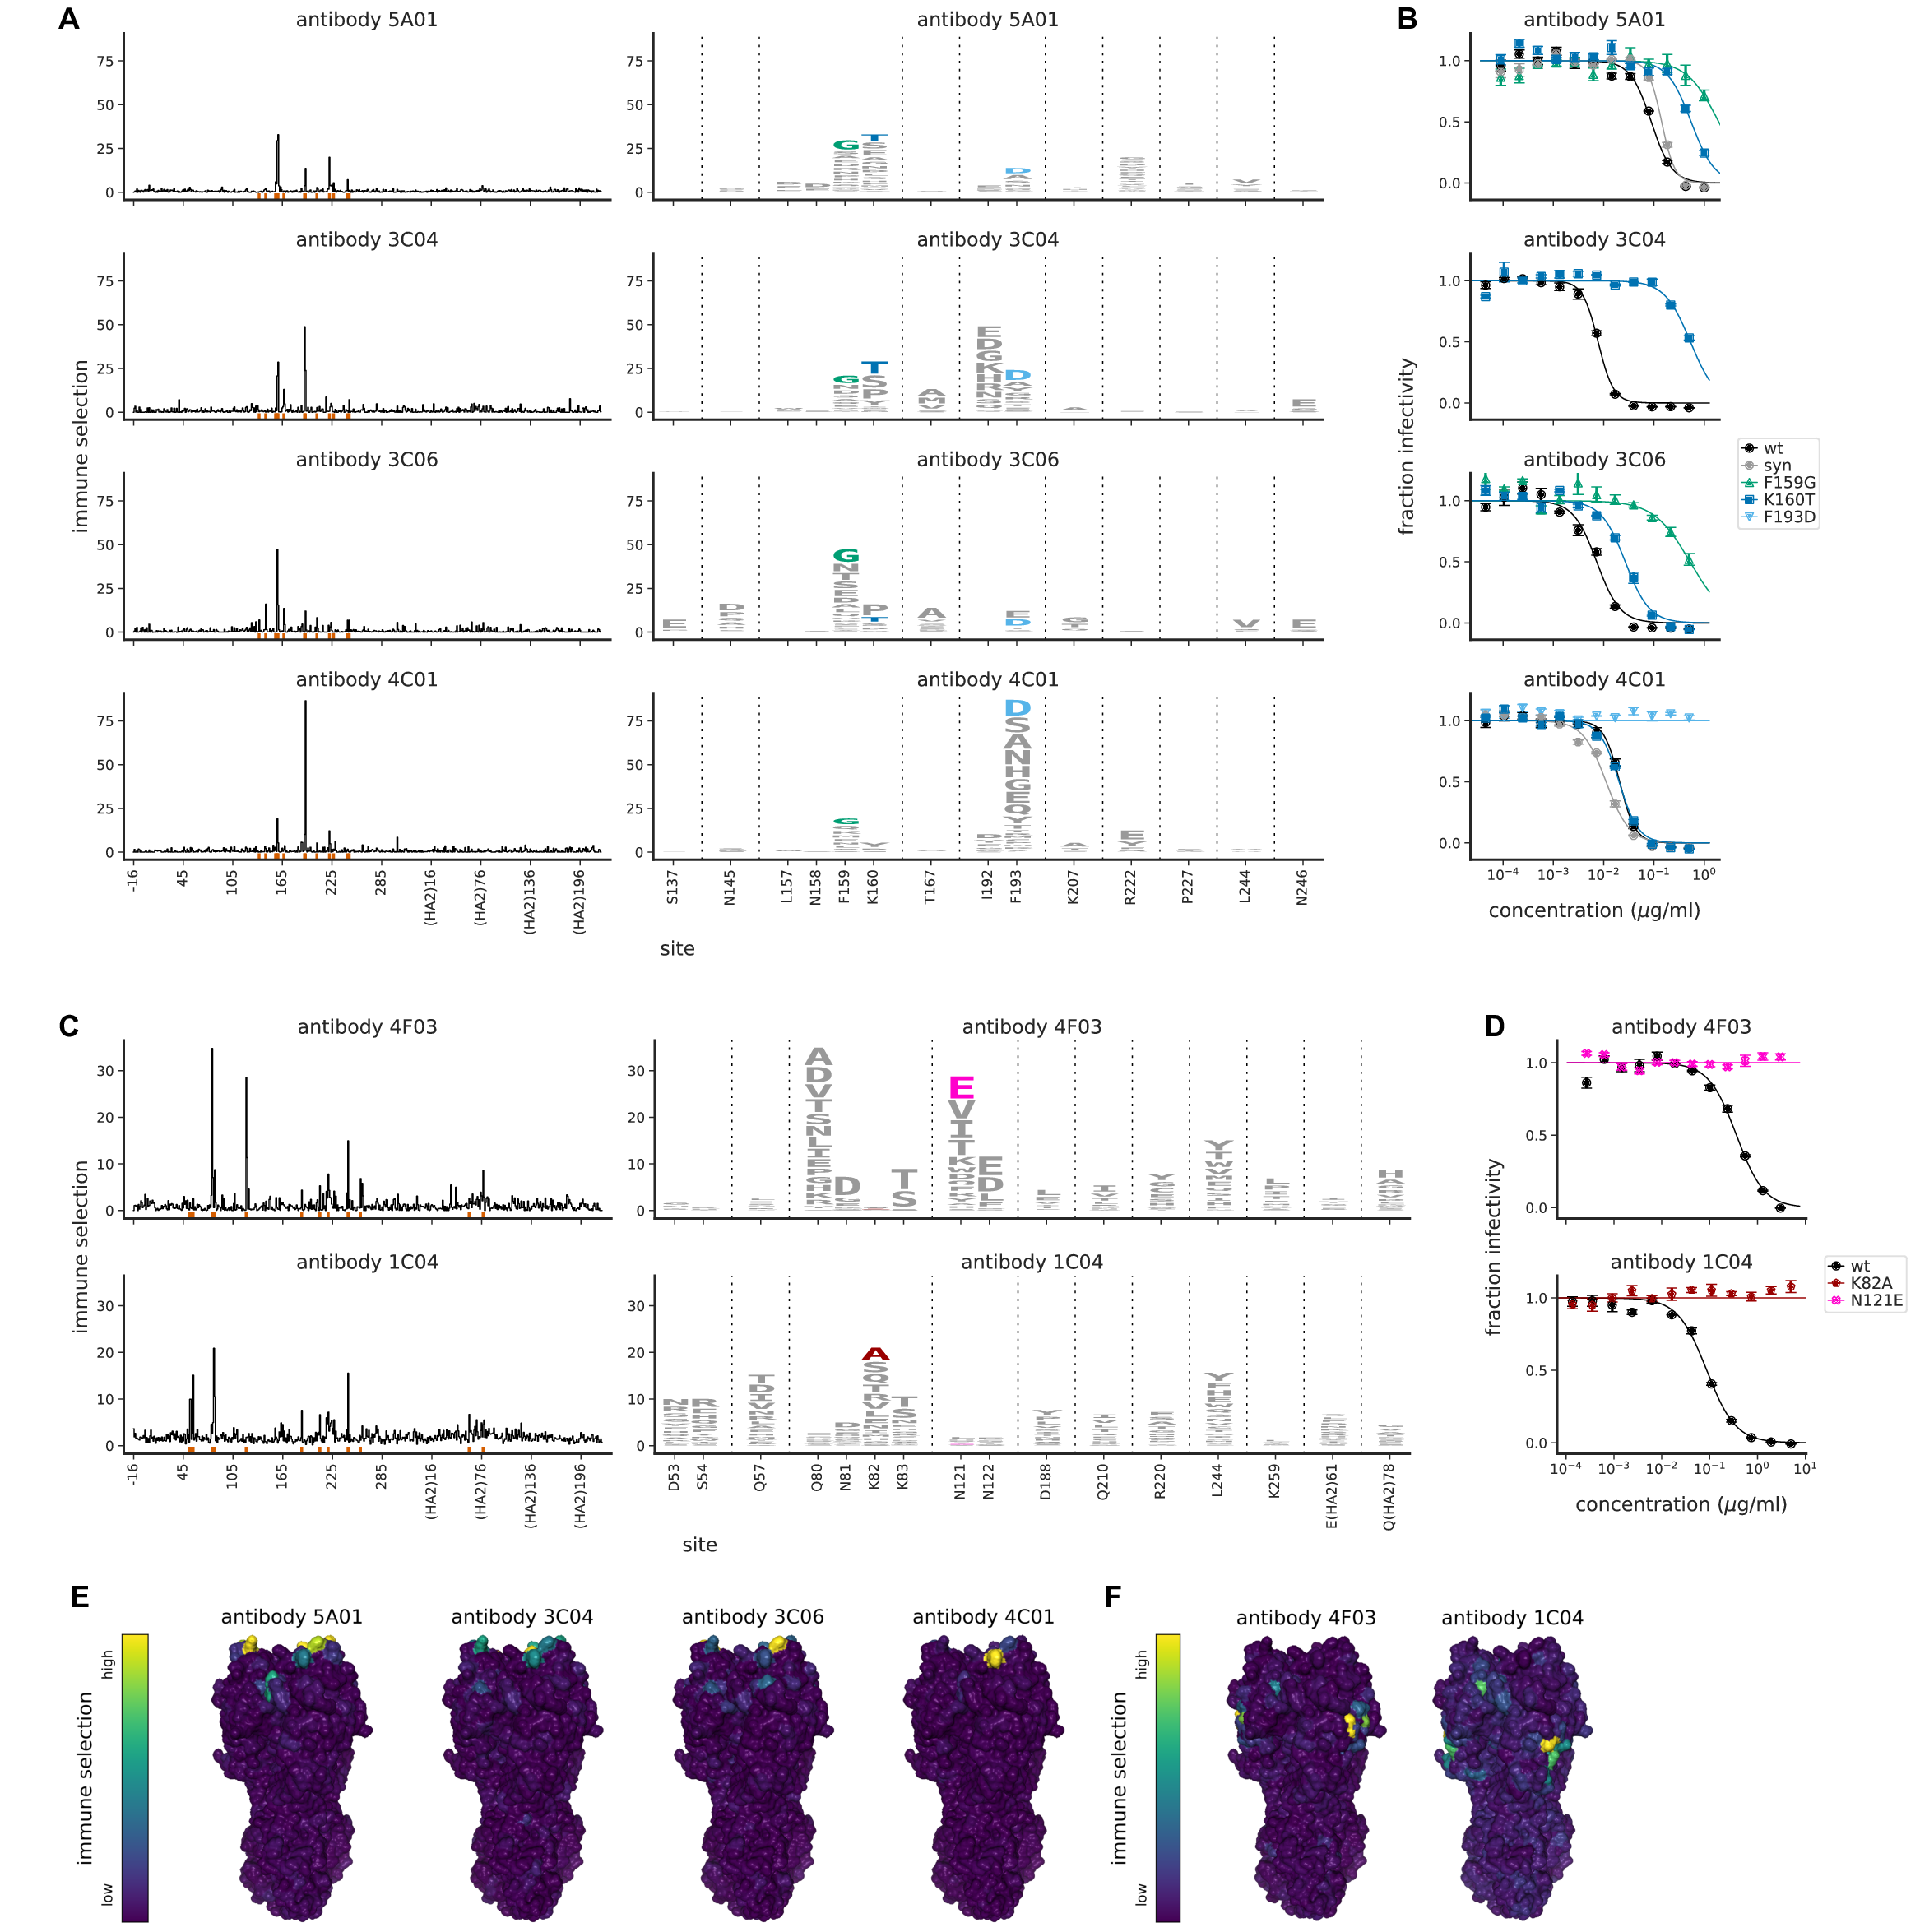

In [8]:
fig_elements = []
height = 0

width = max(svg_dim(os.path.join(config['figsdir'], f"{fig}_logo_and_neut.svg"), 'width')
            for fig in antibodies)

for fig in antibodies:
    figconfig = figure_config['figures'][fig]
    logo_and_neut_svg = os.path.join(config['figsdir'], f"{fig}_logo_and_neut.svg")
    svg_height = svg_dim(logo_and_neut_svg, 'height')
    logo_and_neut_relheight = 2.5 * len(figconfig['sera']) + 0.4 + 1.3
    height += svg_height
    fig_elements.append(svgutils.compose.SVG(logo_and_neut_svg).move(0, height - svg_height))
    height += vmargin

png_height = svg_height * struct_relheight / logo_and_neut_relheight
height += png_height    
for i, fig in enumerate(antibodies):
    figconfig = figure_config['figures'][fig]
    struct_png = os.path.join(config['figsdir'], f"{fig}_struct.png")
    fig_elements.append(svgutils.compose.Image(
                        png_aspect(struct_png) * png_height,
                        png_height,
                        struct_png).move(10 + i * 0.55 * width, height - png_height))
    fig_elements.append(svgutils.compose.Text(figconfig['struct_panel_label'],
                                              15, 5, weight='bold', size='26',
                                              font='Arial').move(10 + i * 0.55 * width,
                                                                 height - png_height))
    
f = svgutils.compose.Figure(width, height, *fig_elements)
svg = os.path.join(config['finalfigsdir'], 'antibodies.svg')
f.save(svg)
pdf = svg_to_pdf(svg)
print(f"\nWriting figure for antibodies to {pdf}")
showPDF(pdf)

## Plots of replicate-replicate correlations
First non-antibody samples:


Replicates for VIDD_sera in results/figures/final/VIDD_sera_corr.svg and results/figures/final/VIDD_sera_corr.pdf:


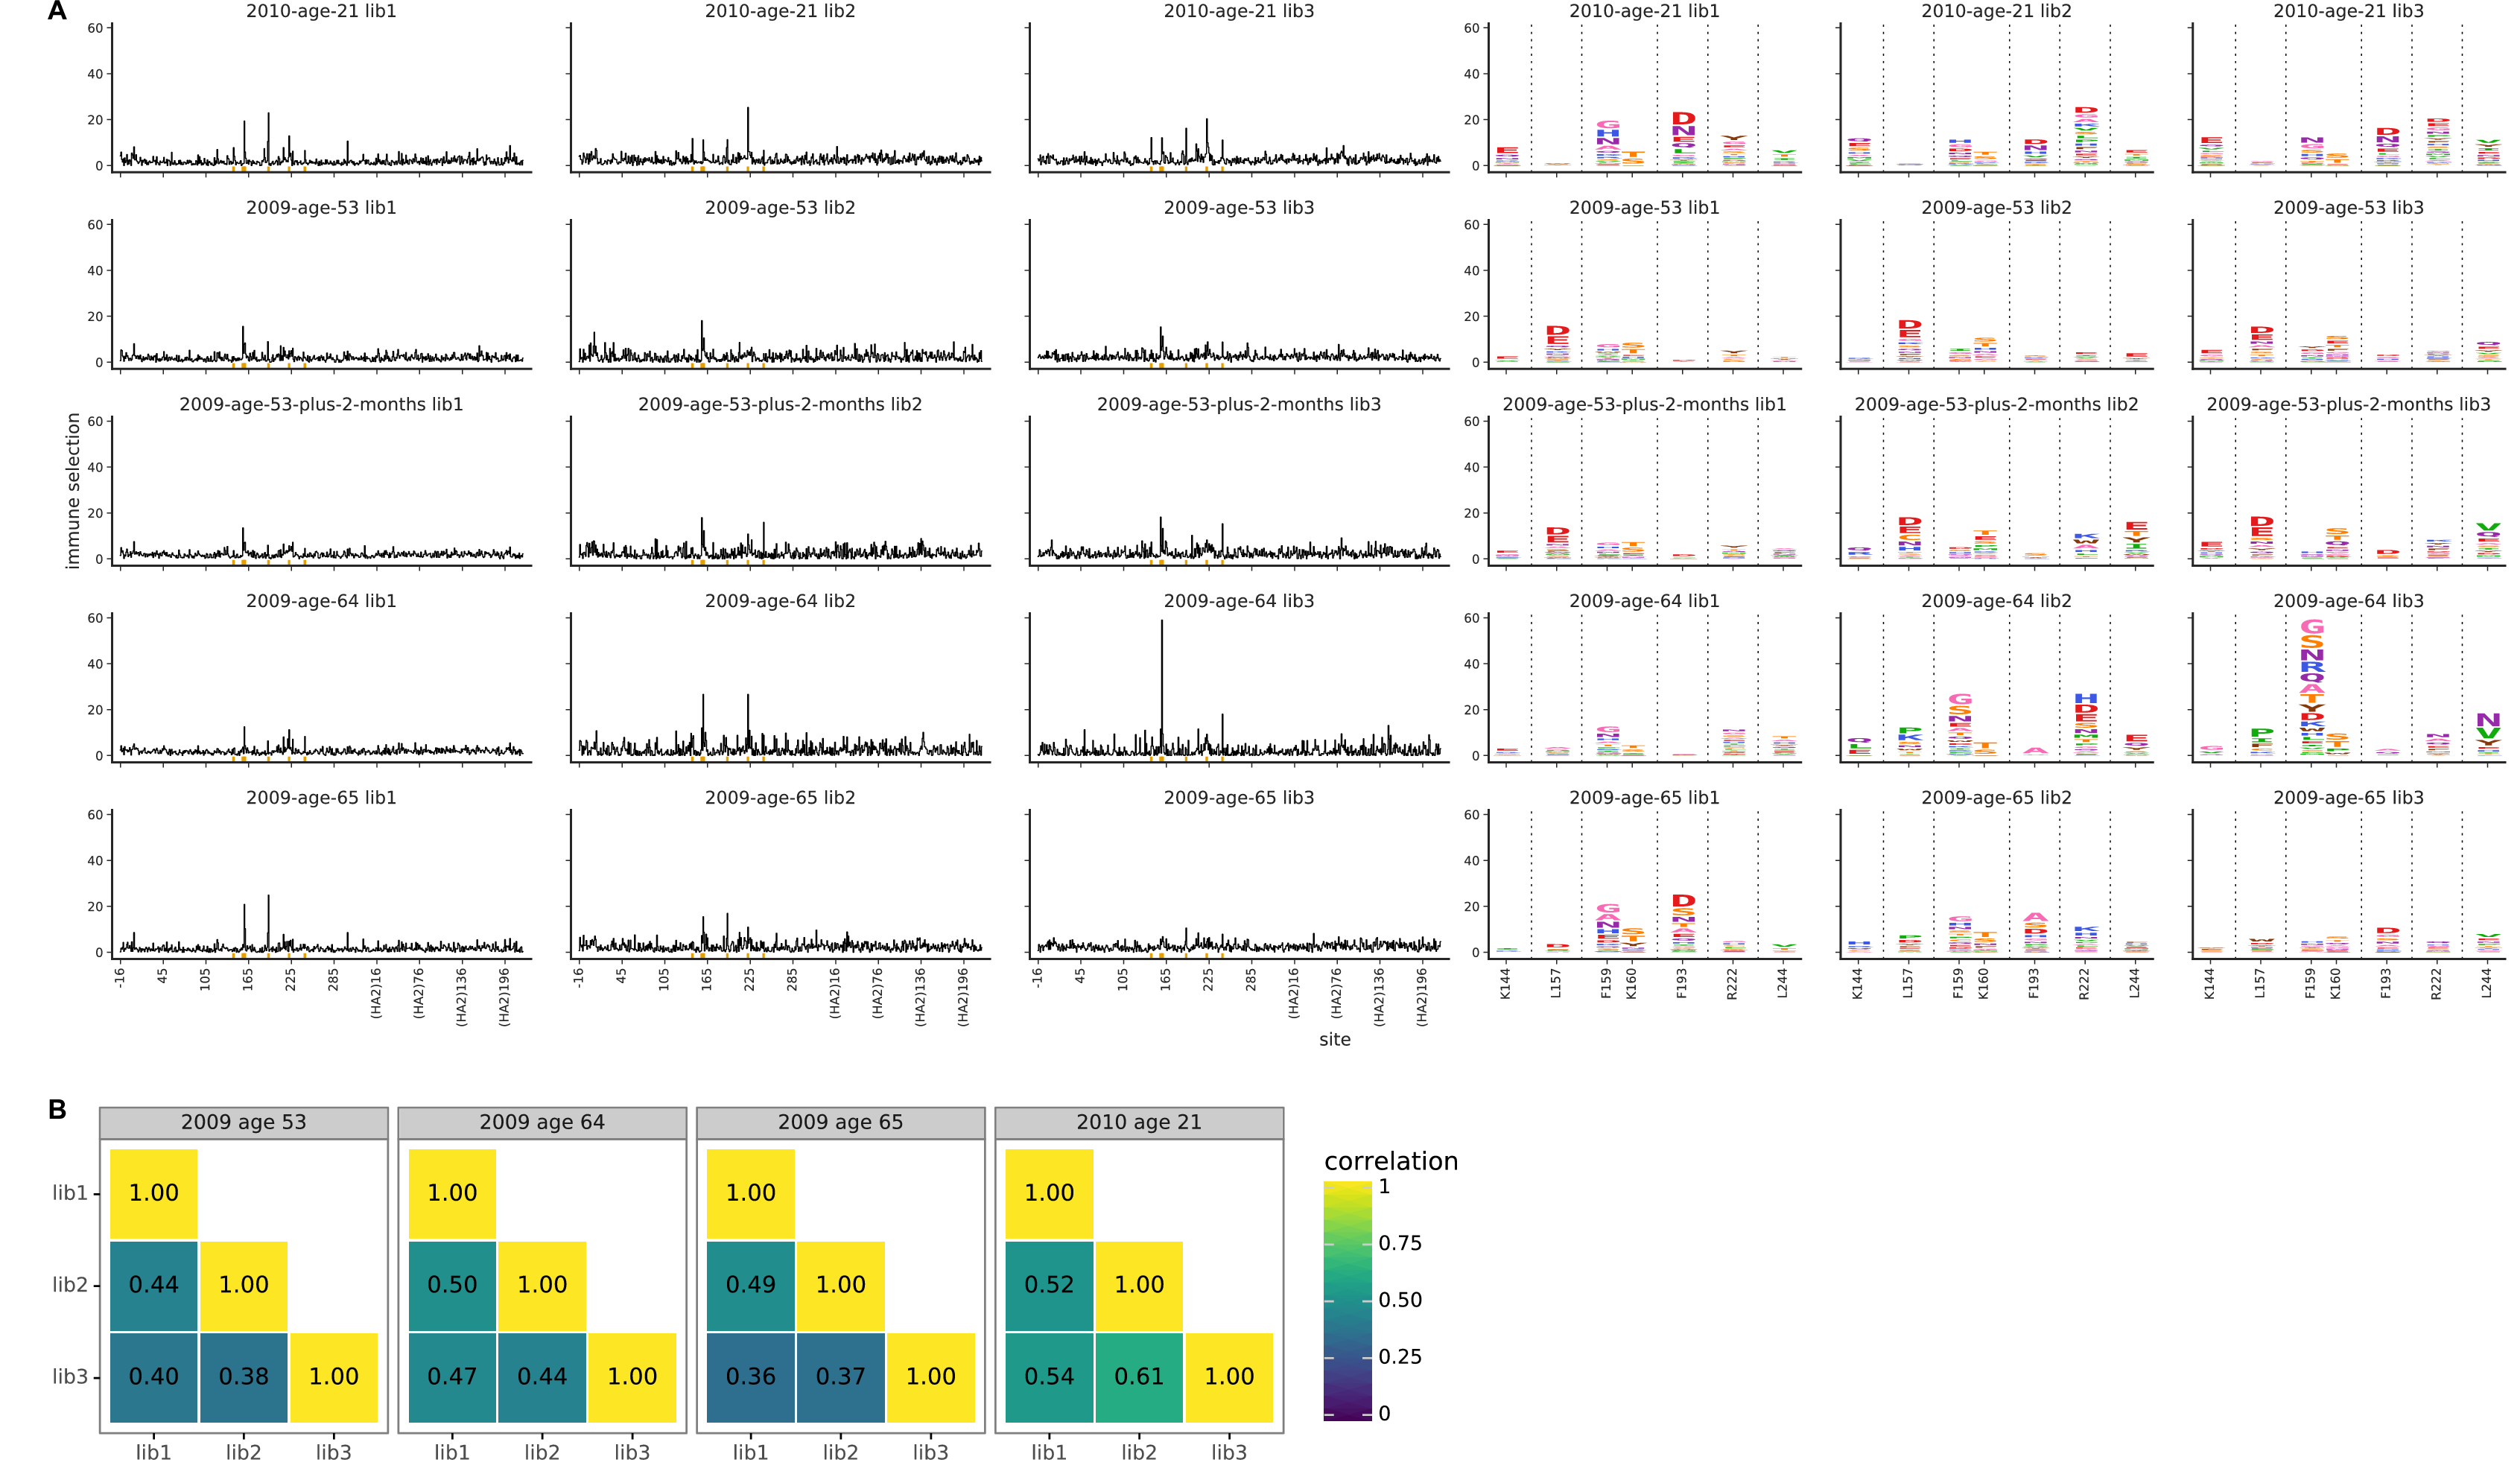


Replicates for 2009_age_53_samples in results/figures/final/2009_age_53_samples_corr.svg and results/figures/final/2009_age_53_samples_corr.pdf:


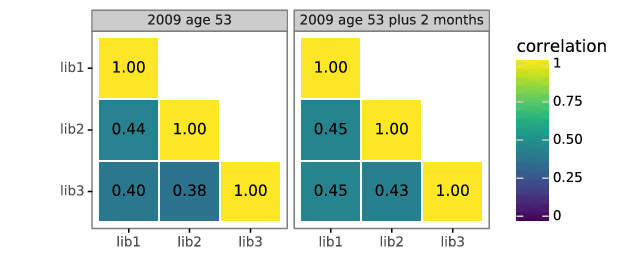


Replicates for Hensley_sera in results/figures/final/Hensley_sera_corr.svg and results/figures/final/Hensley_sera_corr.pdf:


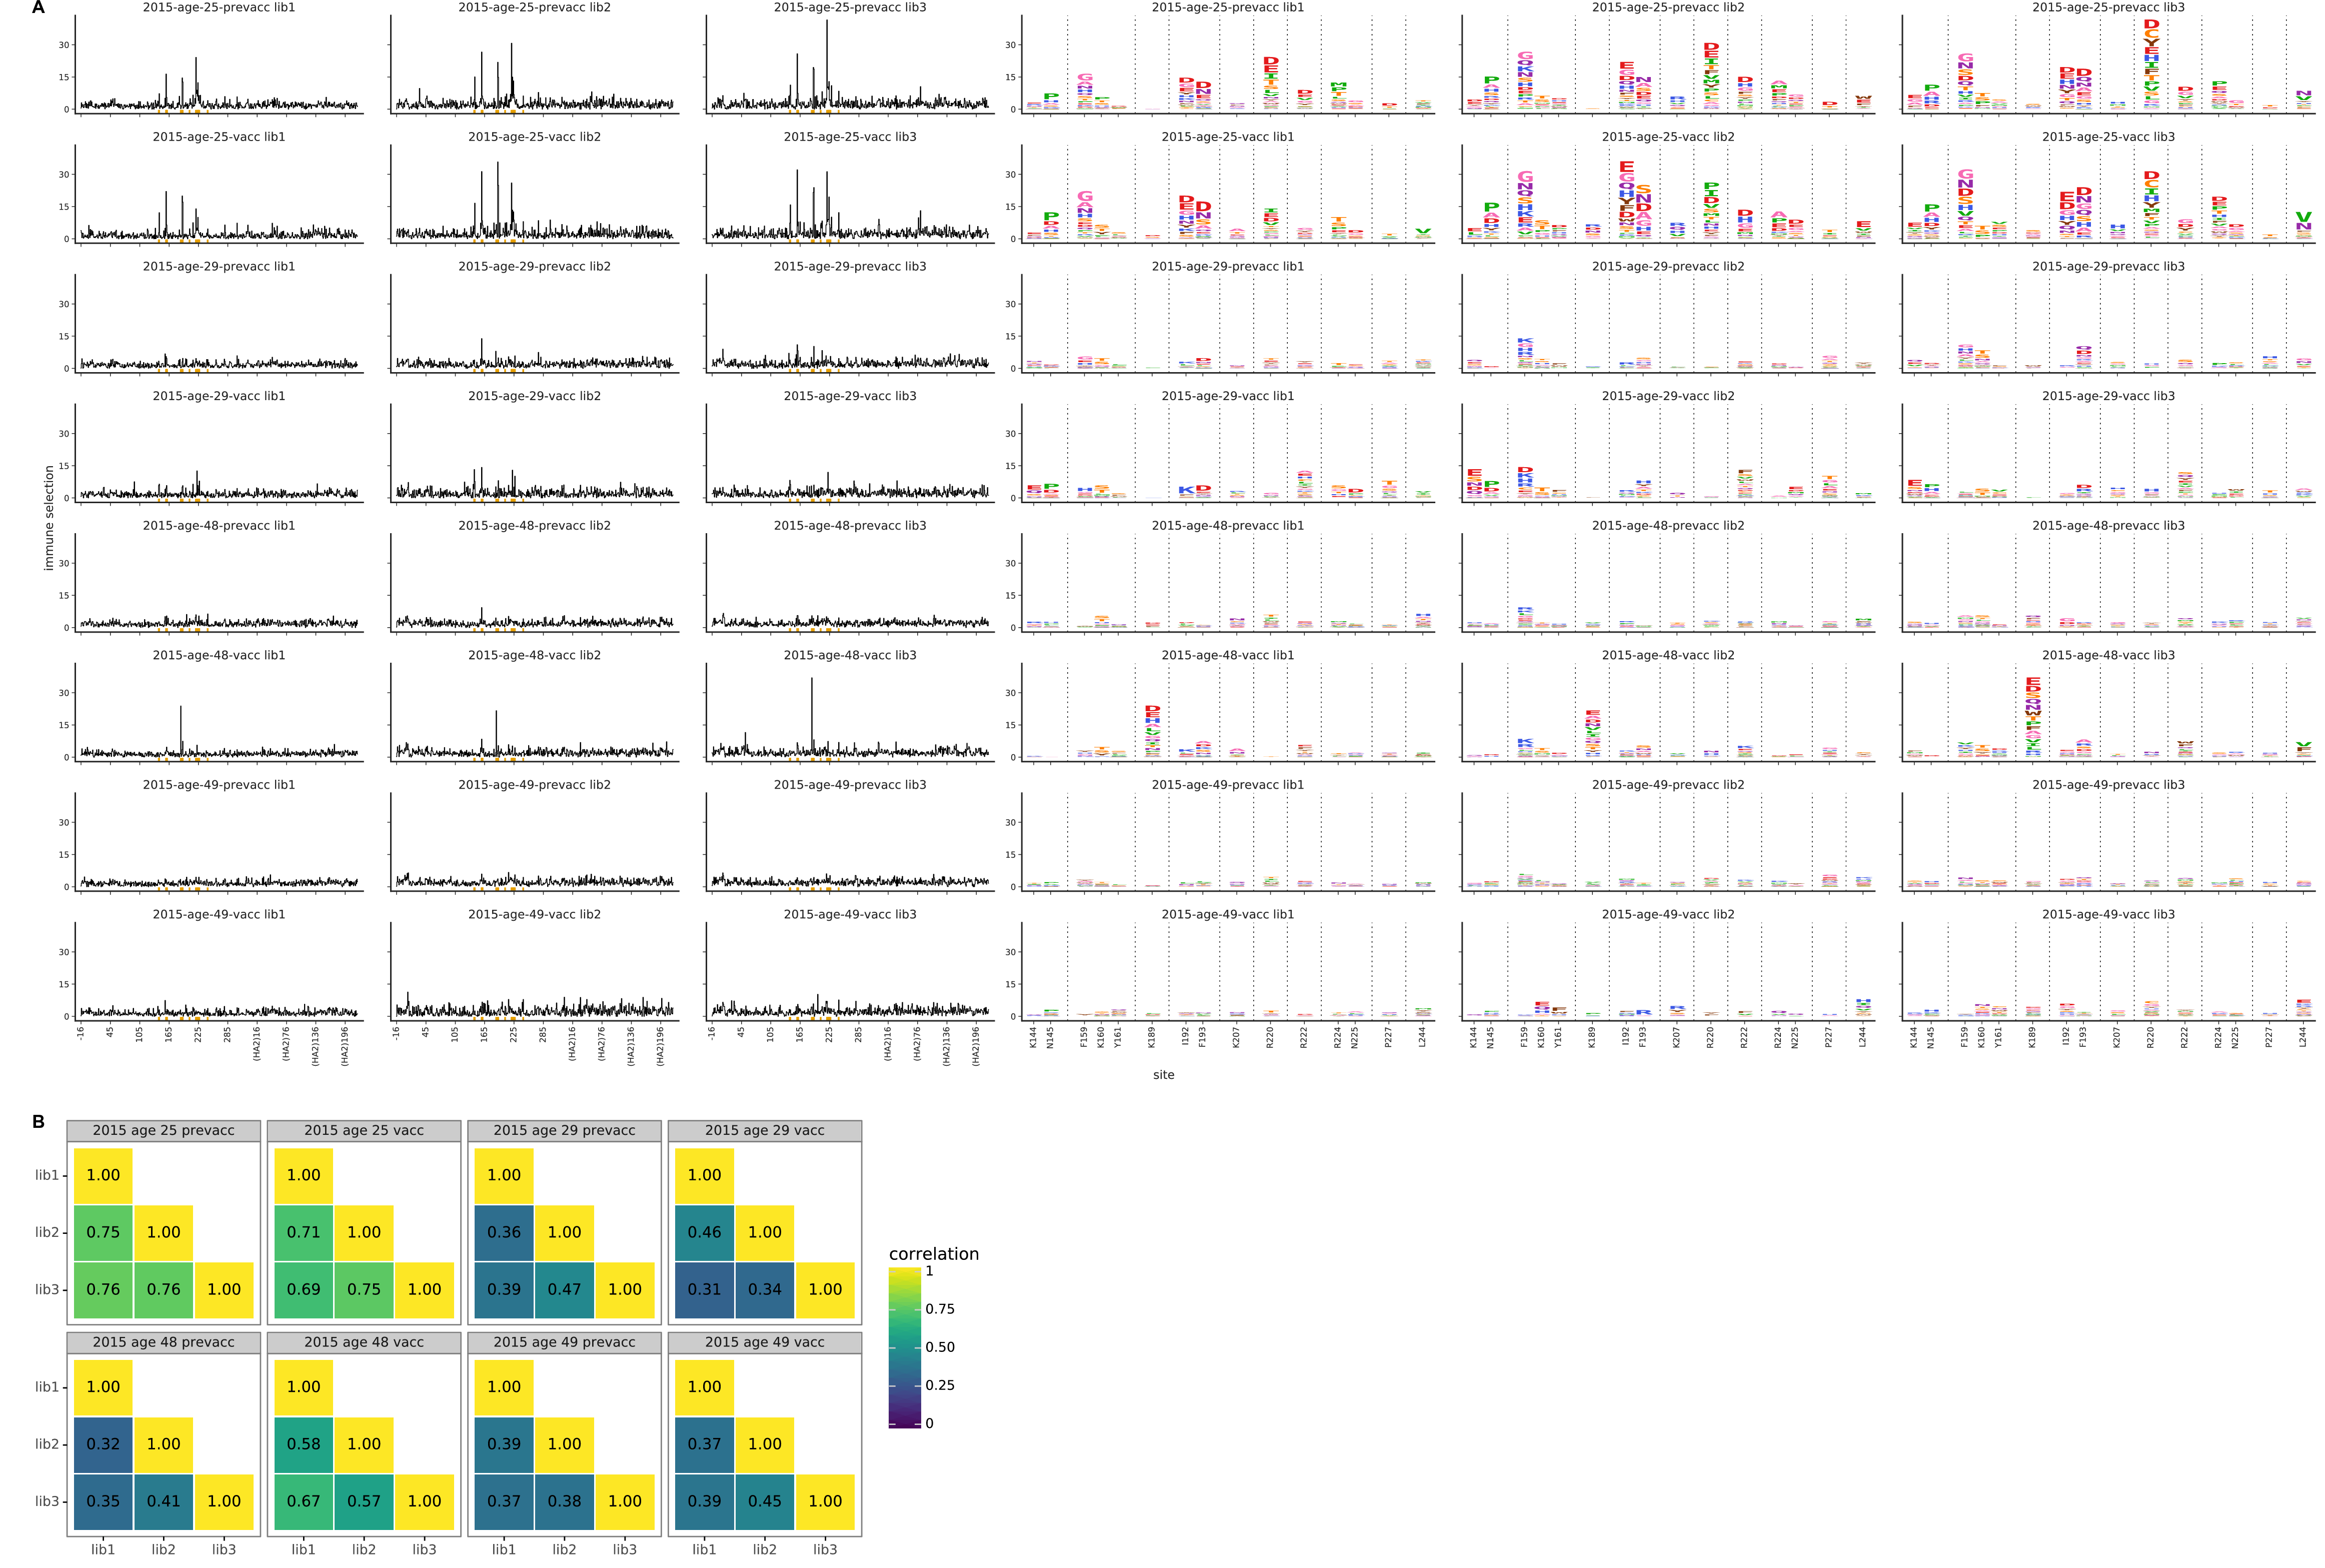


Replicates for ferret in results/figures/final/ferret_corr.svg and results/figures/final/ferret_corr.pdf:


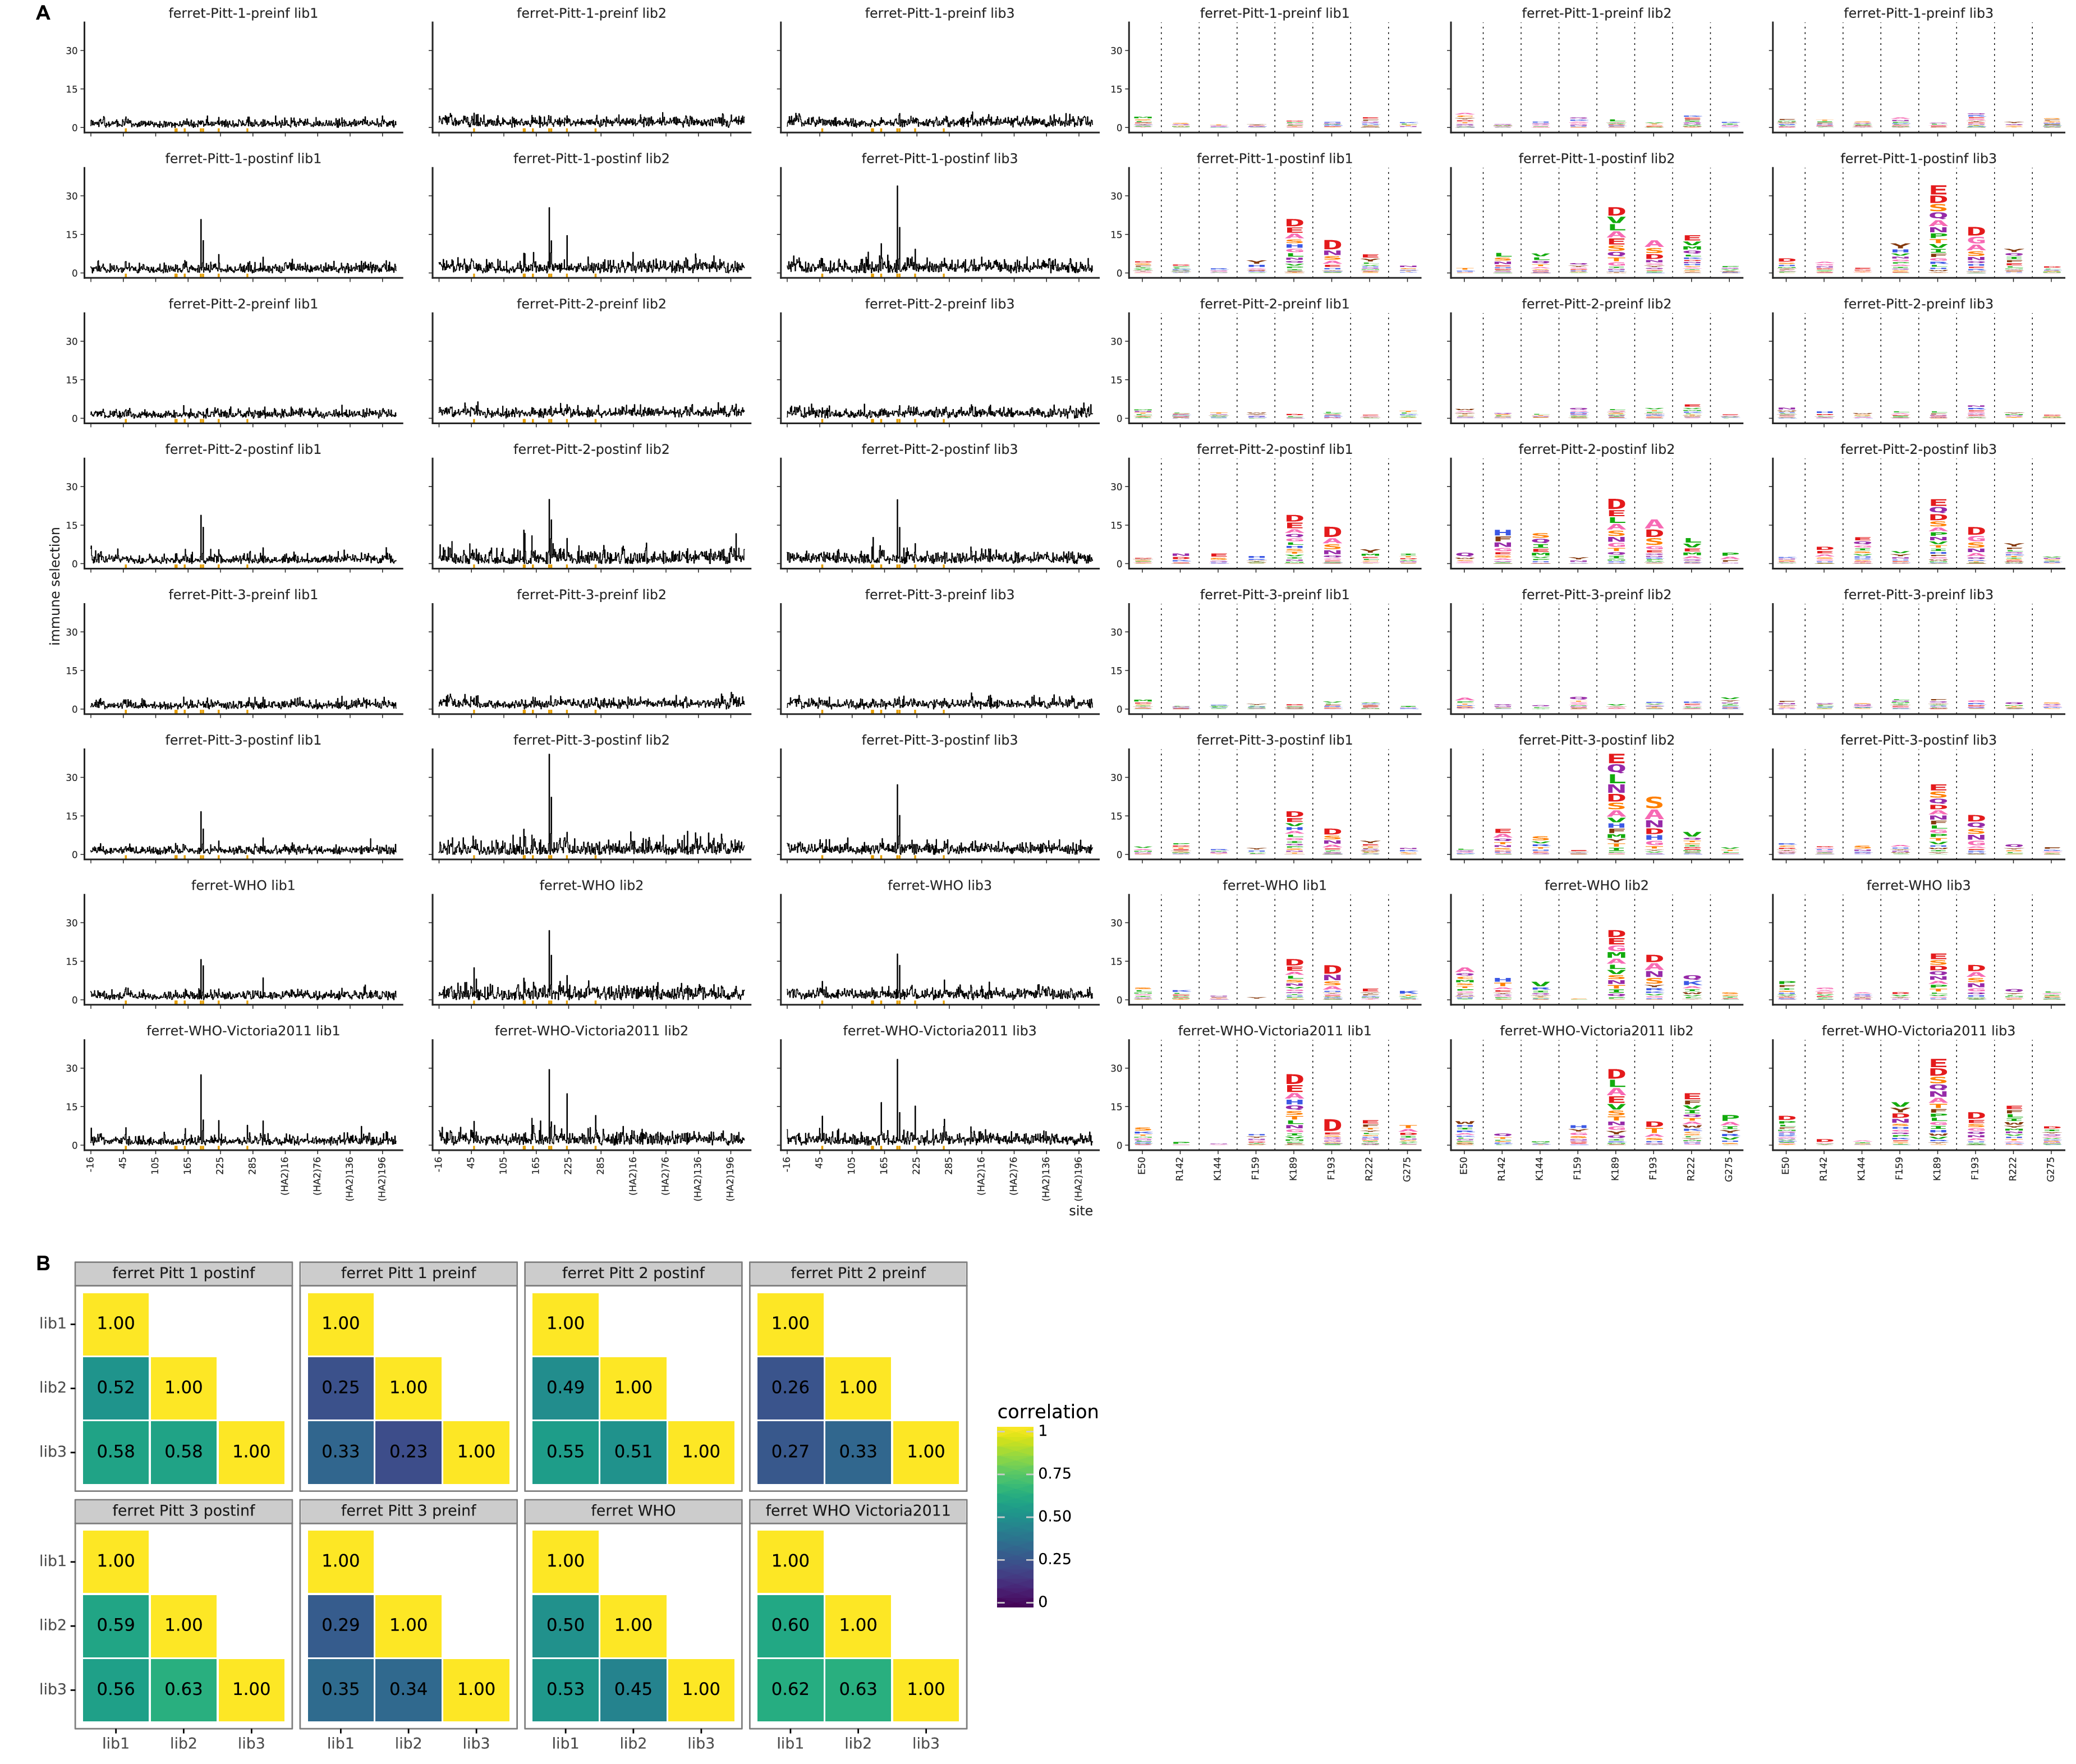


Replicates for antibody_spikein in results/figures/final/antibody_spikein_corr.svg and results/figures/final/antibody_spikein_corr.pdf:


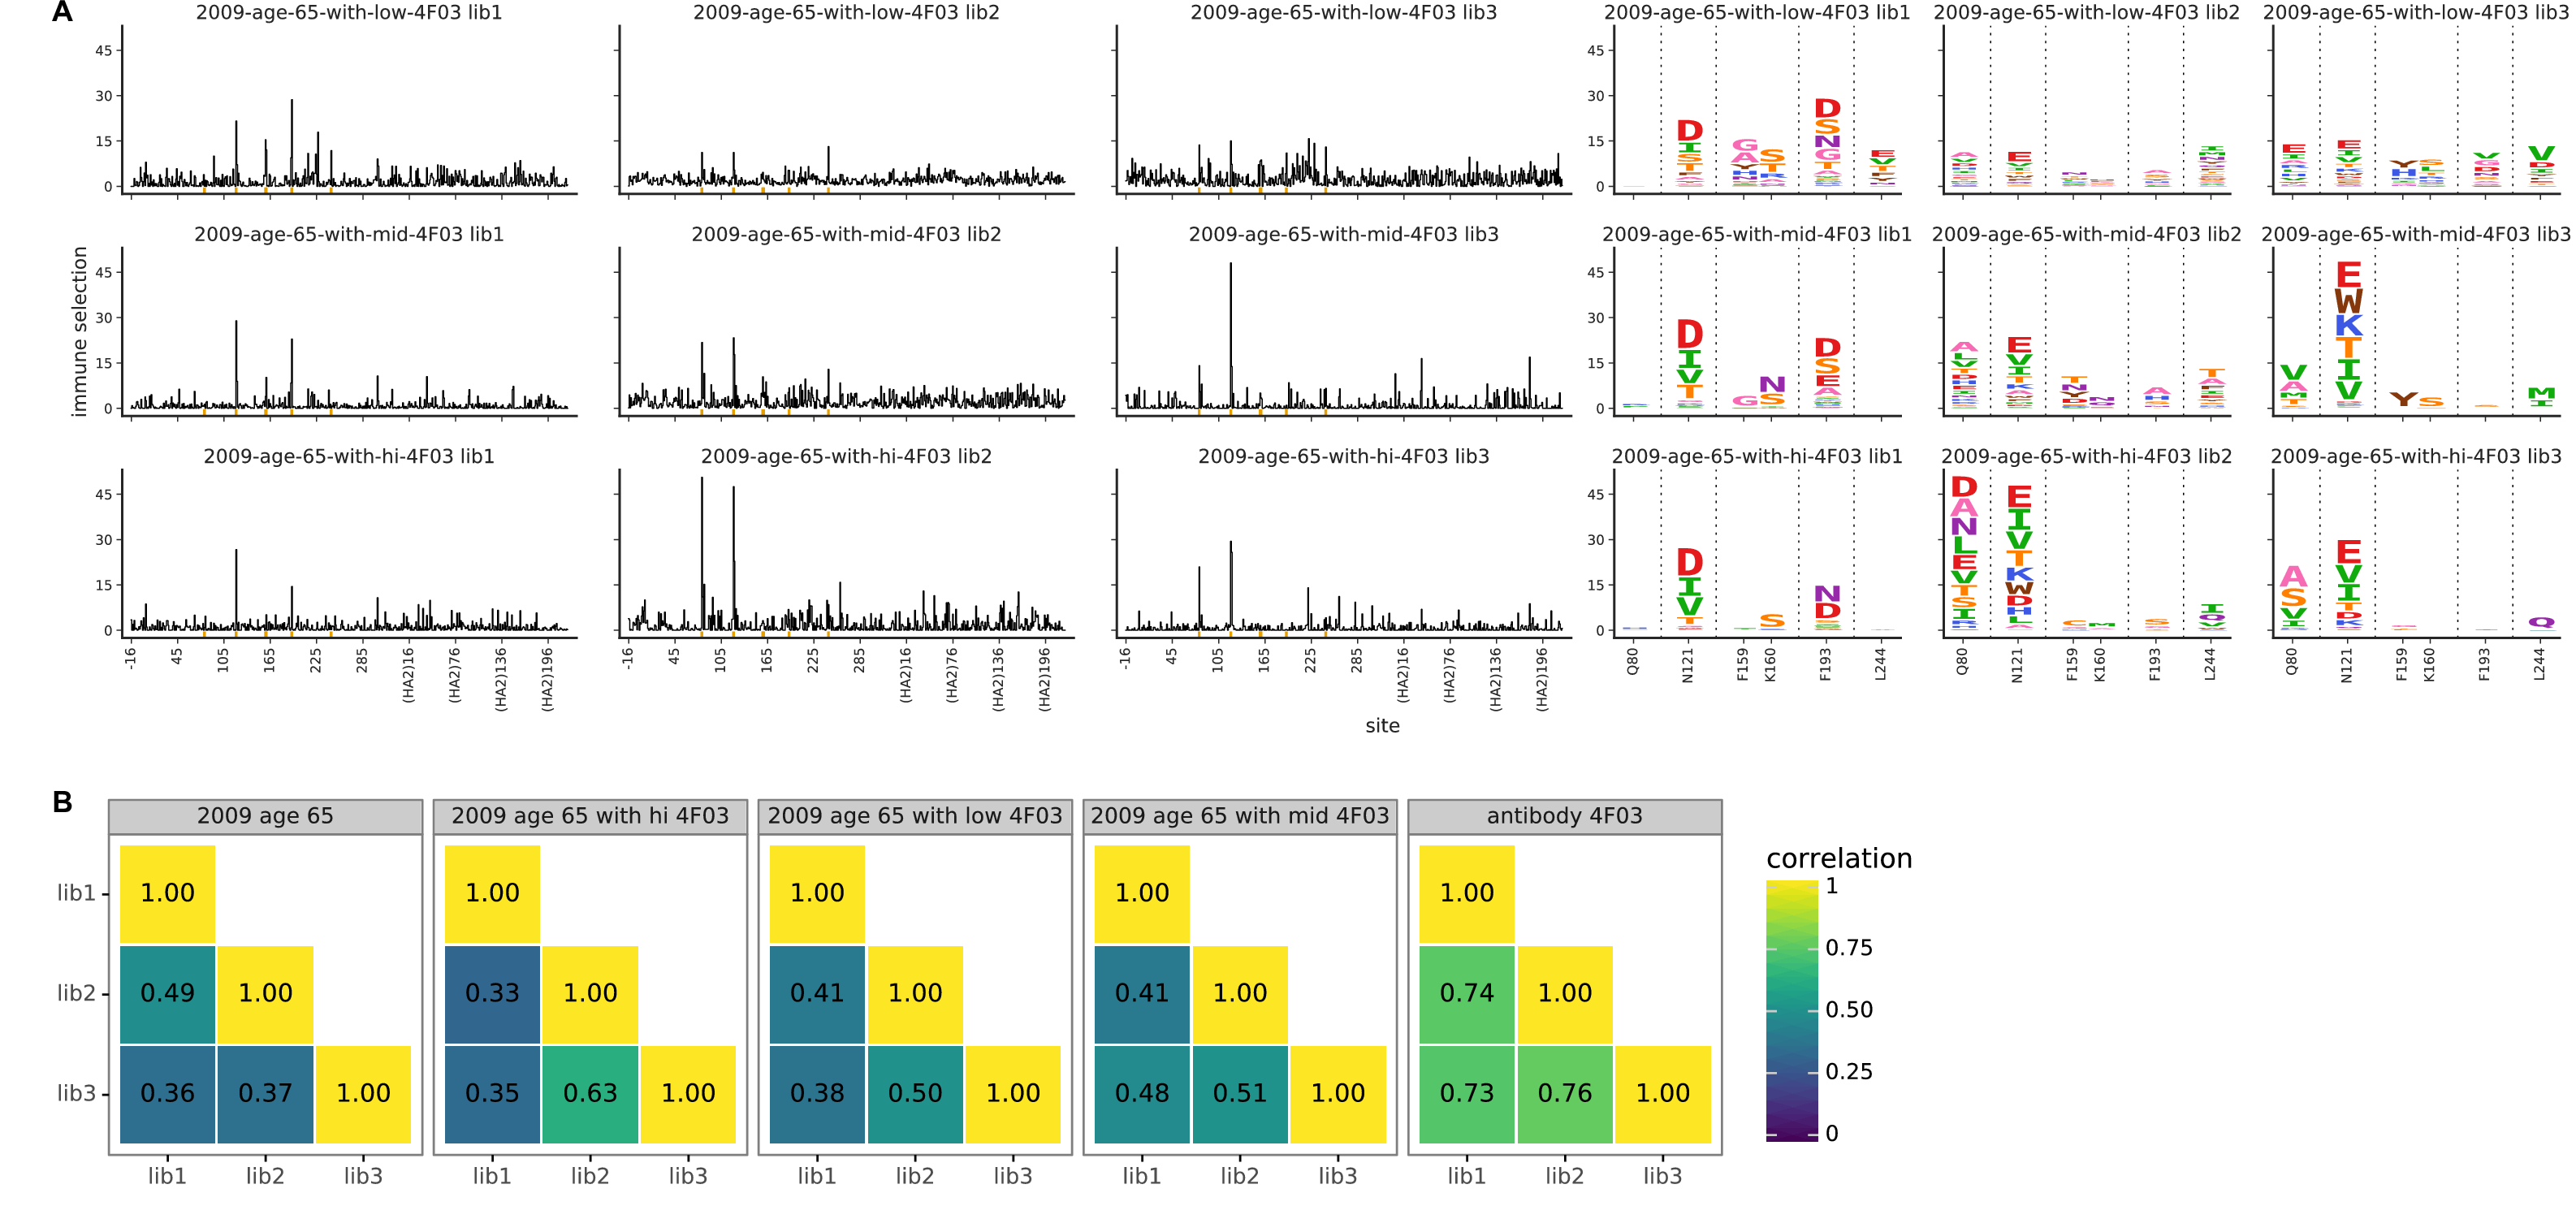

In [9]:
vmargin = 35 # vertical space between panels

for fig, figconfig in figure_config['figures'].items():
    
    if fig in antibodies:
        continue
       
    corr_svg = os.path.join(config['figsdir'], f"{fig}_rep_corr.svg")
    if fig == 'antibody_spikein':
        reps_svg = os.path.join(config['avgdiffsel_reps_dir'], 'serum_mAb_spike_reps.svg')
    else:
        reps_svg = os.path.join(config['avgdiffsel_reps_dir'], f"{fig}_reps.svg")
    fig_elements = []
    height = width = 0
    if fig == '2009_age_53_samples':
        # reps plot for this sample in that for VIDD sera
        letters = ['']
        fig_svgs = [corr_svg]
        scales = [1]
    else:
        letters = string.ascii_uppercase
        fig_svgs = [reps_svg, corr_svg]
        scales = [1, 2]
    for letter, fig_svg, scale in zip(letters, fig_svgs, scales):
        svg_height = svg_dim(fig_svg, 'height') * scale
        height += svg_height
        width = max(svg_dim(fig_svg, 'width') * scale, width)
        fig_elements.append(svgutils.compose.SVG(fig_svg).scale(scale).move(0, height - svg_height))
        fig_elements.append(svgutils.compose.Text(
                            letter, 10, 25, weight='bold', size='26', font='Arial'
                            ).move(0, height - svg_height))
        height += vmargin
    f = svgutils.compose.Figure(width, height, *fig_elements)
    merged_svg = os.path.join(config['finalfigsdir'], f"{fig}_corr.svg")
    f.save(merged_svg)
    merged_pdf = svg_to_pdf(merged_svg)
    print(f"\nReplicates for {fig} in {merged_svg} and {merged_pdf}:")
    showPDF(merged_pdf)

Now antibody samples:


Replicates for antibodies in results/figures/final/antibodies_corr.svg and results/figures/final/antibodies_corr.pdf:


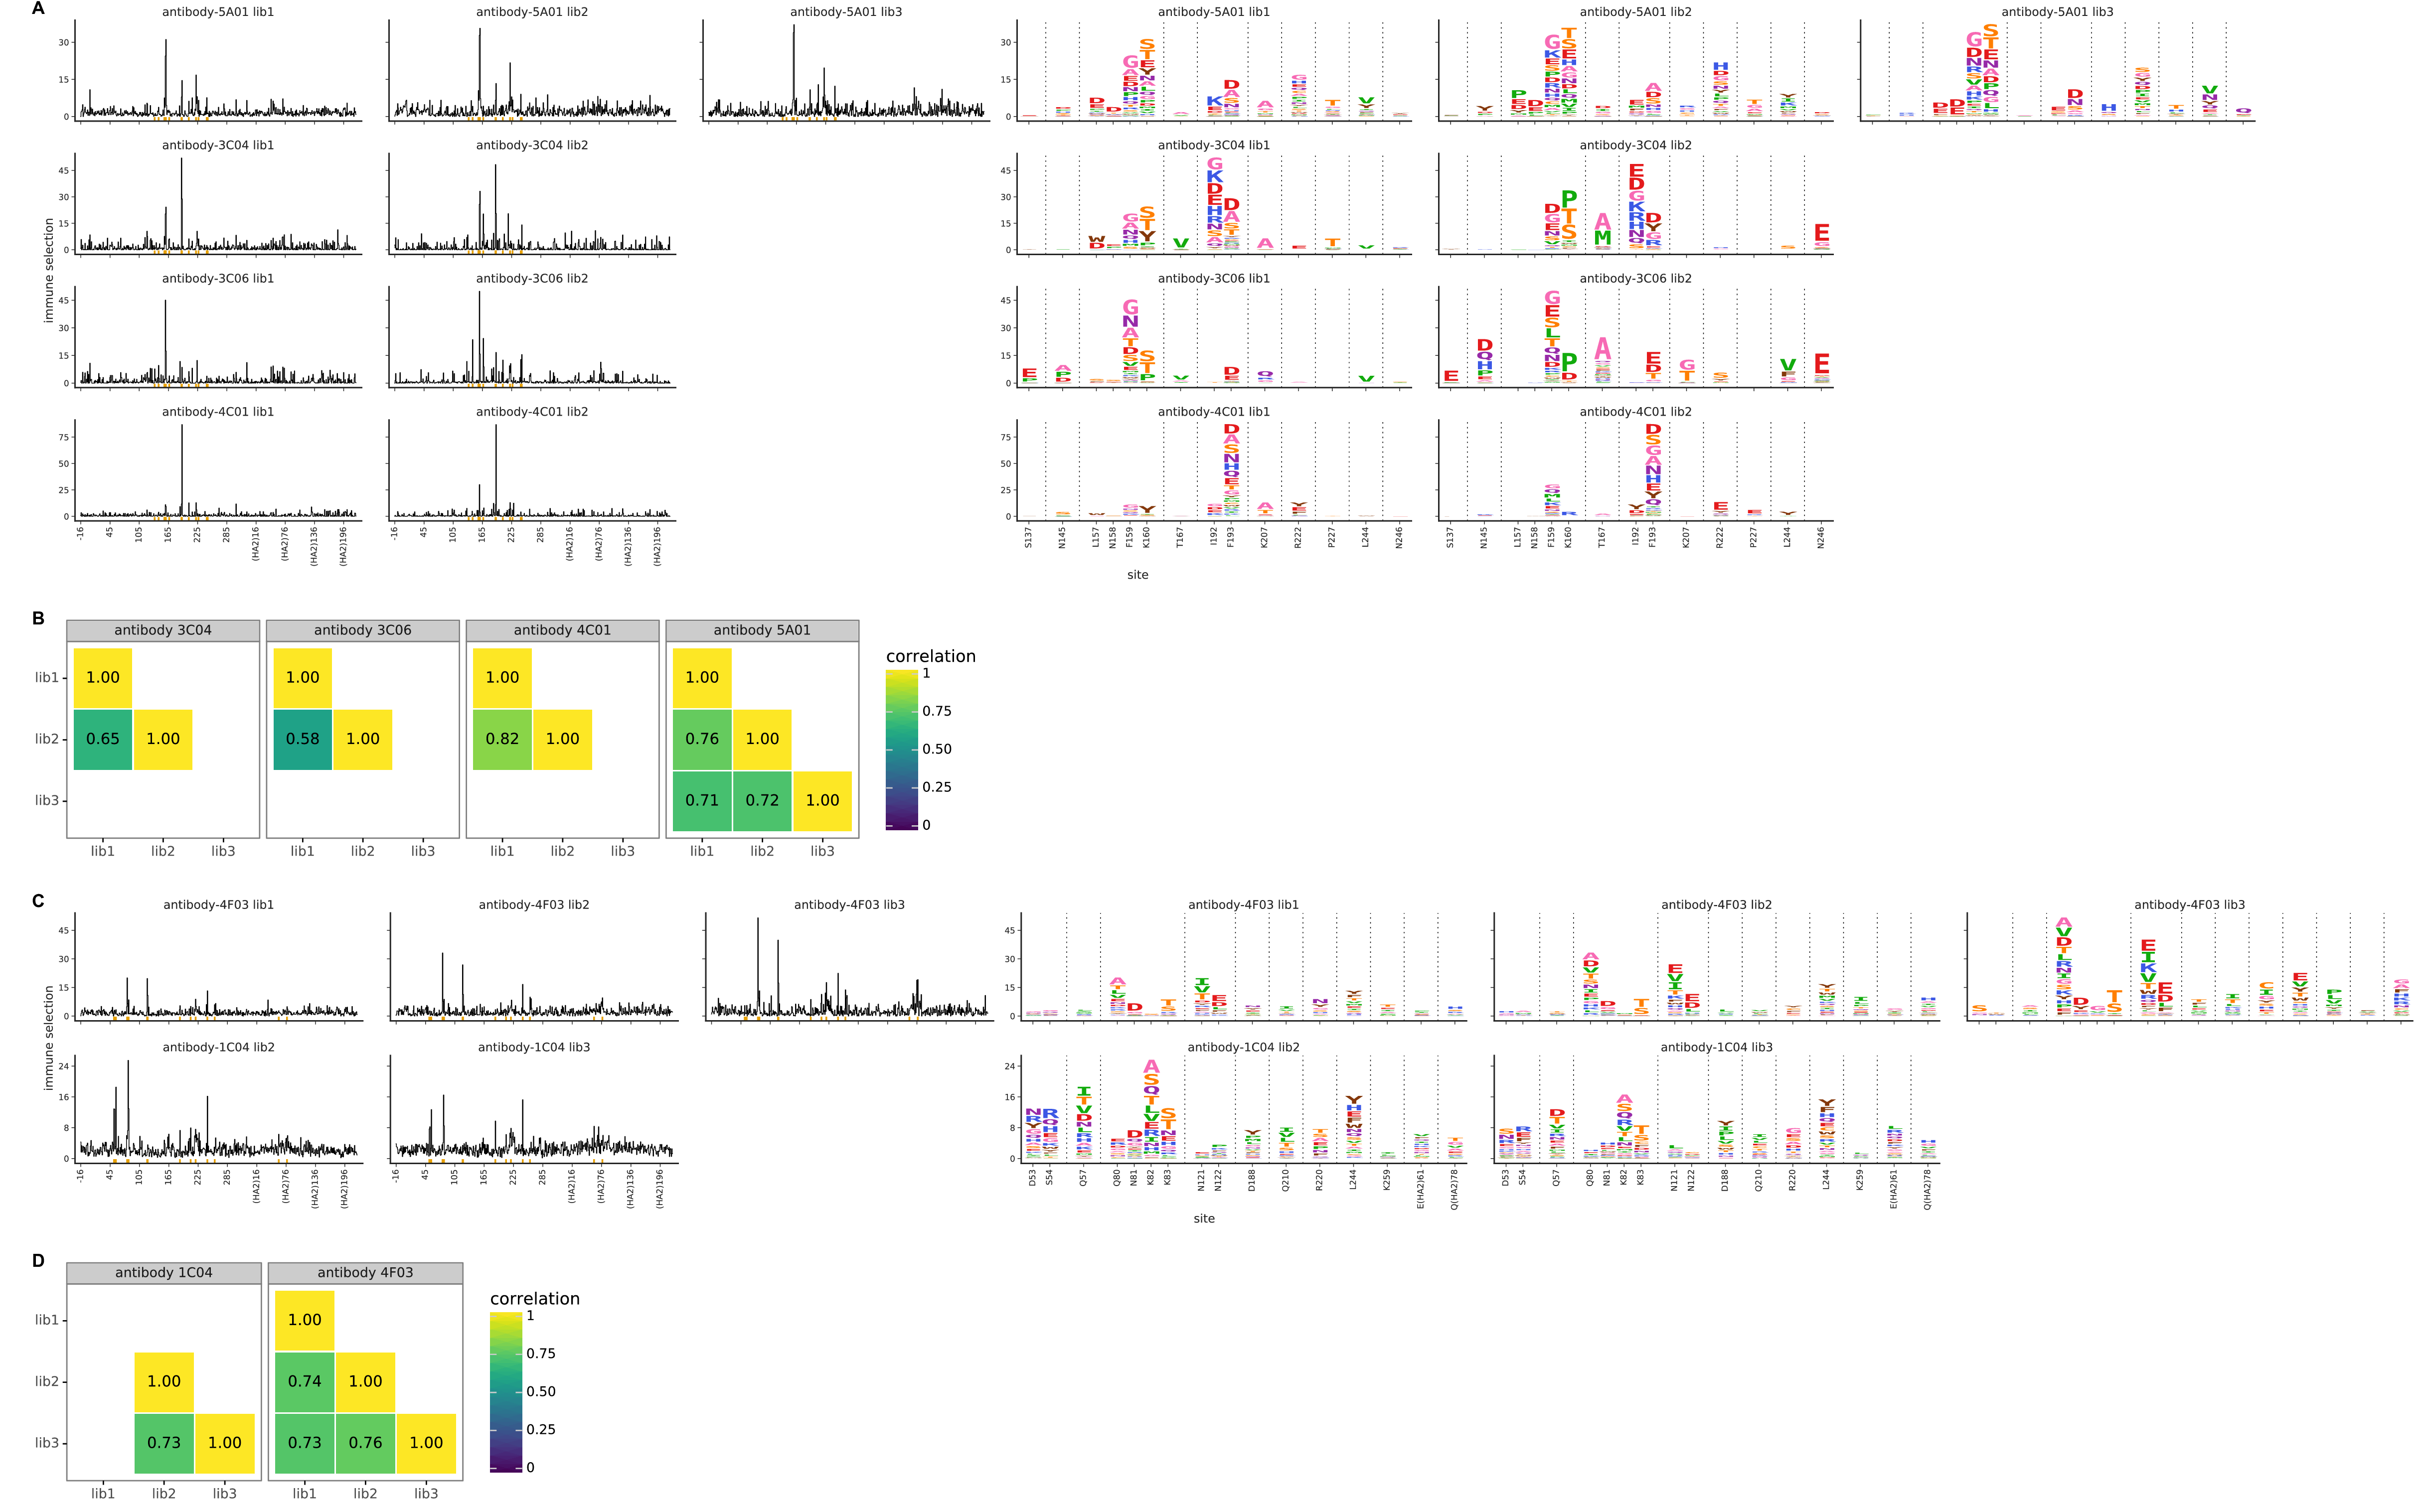

In [10]:
fig_elements = []
height = width = 0
for i, antibody in enumerate(antibodies):
    corr_svg = os.path.join(config['figsdir'], f"{antibody}_rep_corr.svg")
    reps_svg = os.path.join(config['avgdiffsel_reps_dir'], f"{antibody}_reps.svg")
    for letter, fig_svg, scale in zip(string.ascii_uppercase[2 * i: ],
                                      [reps_svg, corr_svg],
                                      [1, 2]):
        svg_height = svg_dim(fig_svg, 'height') * scale
        height += svg_height
        width = max(svg_dim(fig_svg, 'width') * scale, width)
        fig_elements.append(svgutils.compose.SVG(fig_svg).scale(scale).move(0, height - svg_height))
        fig_elements.append(svgutils.compose.Text(
                            letter, 10, 20, weight='bold', size='26', font='Arial'
                            ).move(0, height - svg_height))
        height += vmargin
f = svgutils.compose.Figure(width, height, *fig_elements)
merged_svg = os.path.join(config['finalfigsdir'], f"antibodies_corr.svg")
f.save(merged_svg)
merged_pdf = svg_to_pdf(merged_svg)
print(f"\nReplicates for antibodies in {merged_svg} and {merged_pdf}:")
showPDF(merged_pdf)

## Plots of percent infectivity remaining
First for non-antibody samples:


Percent infectivity for VIDD_sera in results/figures/final/VIDD_sera_percent_infectivity.pdf:


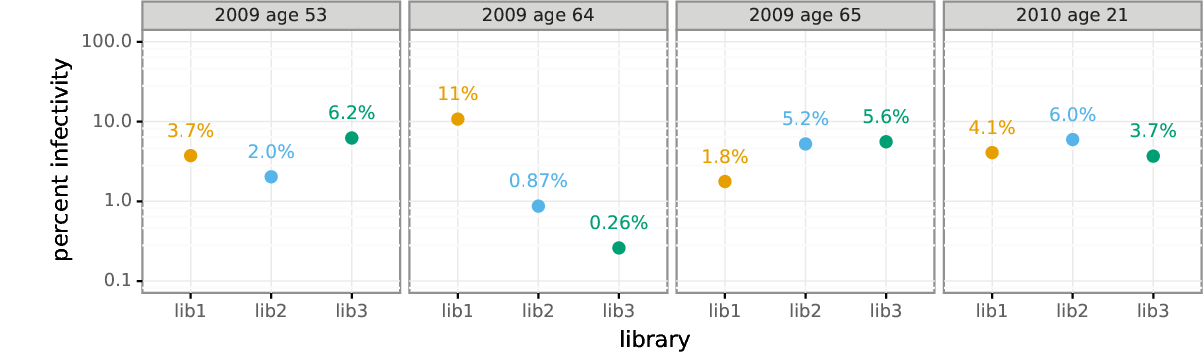


Percent infectivity for 2009_age_53_samples in results/figures/final/2009_age_53_samples_percent_infectivity.pdf:


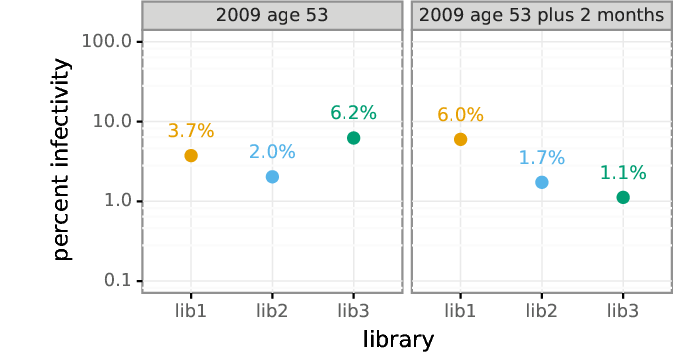


Percent infectivity for Hensley_sera in results/figures/final/Hensley_sera_percent_infectivity.pdf:


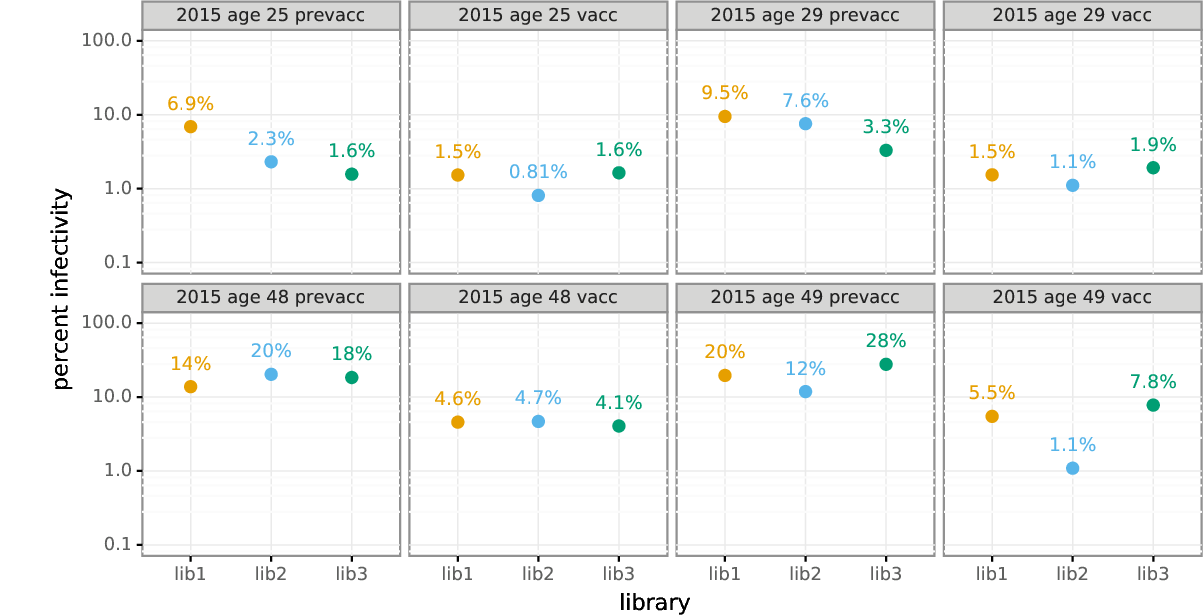


Percent infectivity for ferret in results/figures/final/ferret_percent_infectivity.pdf:


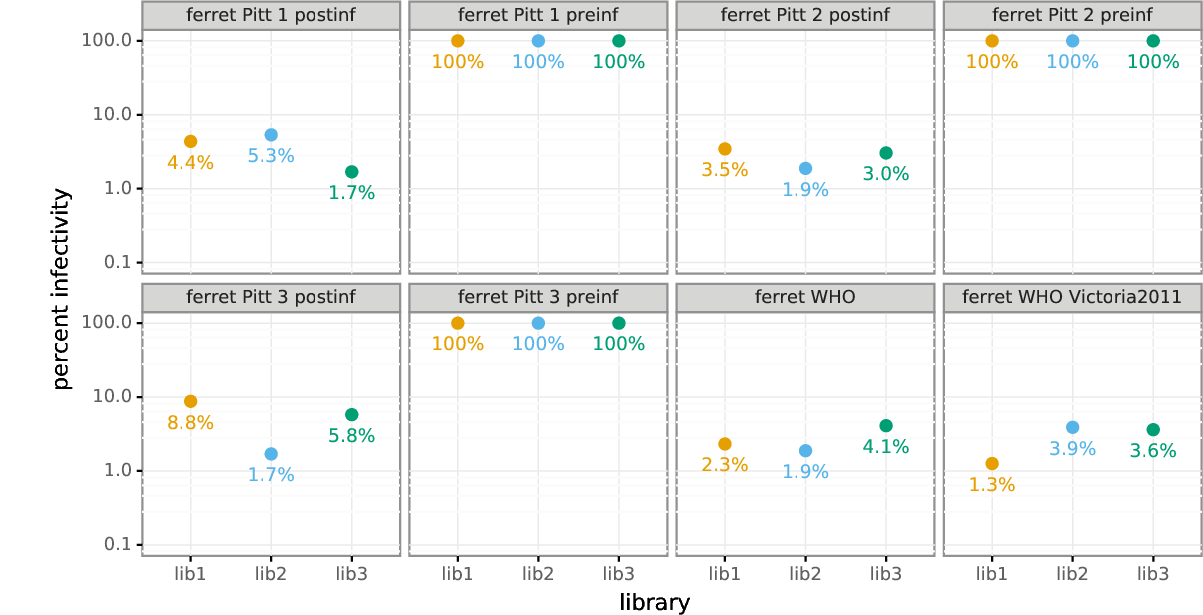

In [11]:
for fig, figconfig in figure_config['figures'].items():
    
    if fig in antibodies or fig == 'antibody_spikein':
        continue
        
    existing_pdf = os.path.join(config['figsdir'],
                                f"{fig}_percent_infectivity.pdf")
    new_pdf = os.path.join(config['finalfigsdir'], os.path.basename(existing_pdf))
    shutil.copy(existing_pdf, new_pdf)
    print(f"\nPercent infectivity for {fig} in {new_pdf}:")
    showPDF(new_pdf)

Now antibody samples:


Writing percent infectivity for antibodies to results/figures/final/antibodies_percent_infectivity.pdf


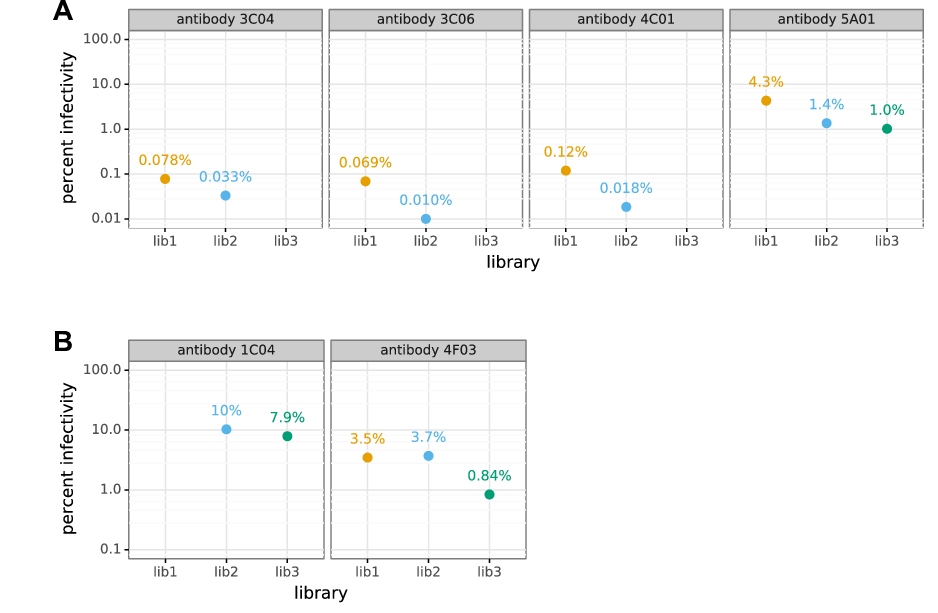

In [12]:
vmargin = 35 # vertical space between panels
fig_elements = []
height = 0
width = 0
for letter, fig in zip(string.ascii_uppercase, antibodies):
    fig_svg = os.path.join(config['figsdir'], f"{fig}_percent_infectivity.svg")
    svg_height = svg_dim(fig_svg, 'height')
    height += svg_height
    width = max(svg_dim(fig_svg, 'width'), width)
    fig_elements.append(svgutils.compose.SVG(fig_svg).move(0, height - svg_height))
    fig_elements.append(svgutils.compose.Text(
                            letter, 15, 0, weight='bold', size='20', font='Arial'
                            ).move(-13, height - svg_height + 0.43 * vmargin))
    height += vmargin
    
f = svgutils.compose.Figure(width, height, *fig_elements)
svg = os.path.join(config['finalfigsdir'], 'antibodies_percent_infectivity.svg')
f.save(svg)
pdf = svg_to_pdf(svg)
print(f"\nWriting percent infectivity for antibodies to {pdf}")
showPDF(pdf)

## Plots of percent infectivity remaining for spikein

Get data frame with samples of interest:

In [13]:
fig = 'antibody_spikein'
sera_names = figure_config['figures'][fig]['sera_names']

with open(config['serum_info']) as f:
    serum_info = yaml.safe_load(f)

samples = (pd.read_csv(config['sample_list'])
           [['serum', 'percent_infectivity', 'library', 'sample']]
           .assign(serum=lambda x: x['serum'].map({serumlabel: d['name'] for serumlabel, d
                                                   in serum_info.items()})
                   )
           .query('serum in @sera_names')
           .assign(serum=lambda x: x['serum'].map(sera_names).str.replace('\+ \w+', '+'))
           .assign(antibody_conc=lambda x: x.sort_values('percent_infectivity', ascending=False)
                                            .groupby(['serum', 'library'])
                                            .cumcount()
                                            .astype('category')
                                            .cat
                                            .rename_categories({0: 'low', 1: 'mid', 2: 'high'}),
                   label=lambda x: x['percent_infectivity']
                                     .apply(lambda y: '{0:#.2g}'.format(y))
                                     .apply(lambda y: y[: -1] if y[-1] == '.' else y),
                   )
           .sort_values(['serum', 'library', 'antibody_conc'])
           )

# serum is the same for all
samples = (pd.concat(
            [samples.query('serum != "serum alone"'),
             samples.query('serum == "serum alone"')
                    .drop(columns='antibody_conc')
                    .merge(samples[['library', 'antibody_conc']].drop_duplicates())
             ],
            sort=False).reset_index(drop=True)
           .assign(label_x=lambda x: x['antibody_conc'].cat.codes + 1 +
                                     0.6 * (x['serum'] == 'antibody alone').astype('int'),
                   label_y=lambda x: x['percent_infectivity'] +
                                     1.2 * (x['serum'] == 'serum alone'))
           )

samples

serum  percent_infectivity library            sample  \
0     antibody alone              28.2400    lib1        L4-4F03-c1   
1     antibody alone               3.4700    lib1        L4-4F03-c2   
2     antibody alone               0.7800    lib1        L4-4F03-c3   
3     antibody alone              22.9900    lib2        L5-4F03-c1   
4     antibody alone               4.7100    lib2        L5-4F03-c2   
5     antibody alone               3.7100    lib2        L5-4F03-c3   
6     antibody alone              23.9100    lib3        L6-4F03-c1   
7     antibody alone               7.1600    lib3        L6-4F03-c2   
8     antibody alone               0.8400    lib3        L6-4F03-c3   
9   serum + antibody               0.0300    lib1  L4-VIDD5-low4F03   
10  serum + antibody               0.0037    lib1  L4-VIDD5-mid4F03   
11  serum + antibody               0.0016    lib1   L4-VIDD5-hi4F03   
12  serum + antibody               5.0000    lib2  L5-VIDD5-low4F03   
13  serum + antibody               0.4600    lib2  L5-VIDD5-mid4F03   
14  serum + antibody               0.0400    lib2   L5-VIDD5-hi4F03   
15  serum + antibody               0.2040    lib3  L6-VIDD5-low4F03   
16  serum + antibody               0.0077    lib3  L6-VIDD5-mid4F03   
17  serum + antibody               0.0032    lib3   L6-VIDD5-hi4F03   
18       serum alone               1.7700    lib1          L4-VIDD5   
19       serum alone               1.7700    lib1          L4-VIDD5   
20       serum alone               1.7700    lib1          L4-VIDD5   
21       serum alone               5.2400    lib2          L5-VIDD5   
22       serum alone               5.2400    lib2          L5-VIDD5   
23       serum alone               5.2400    lib2          L5-VIDD5   
24       serum alone               5.5800    lib3          L6-VIDD5   
25       serum alone               5.5800    lib3          L6-VIDD5   
26       serum alone               5.5800    lib3          L6-VIDD5   

   antibody_conc   label  label_x  label_y  
0            low      28      1.6  28.2400  
1            mid     3.5      2.6   3.4700  
2           high    0.78      3.6   0.7800  
3            low      23      1.6  22.9900  
4            mid     4.7      2.6   4.7100  
5           high     3.7      3.6   3.7100  
6            low      24      1.6  23.9100  
7            mid     7.2      2.6   7.1600  
8           high    0.84      3.6   0.8400  
9            low   0.030      1.0   0.0300  
10           mid  0.0037      2.0   0.0037  
11          high  0.0016      3.0   0.0016  
12           low     5.0      1.0   5.0000  
13           mid    0.46      2.0   0.4600  
14          high   0.040      3.0   0.0400  
15           low    0.20      1.0   0.2040  
16           mid  0.0077      2.0   0.0077  
17          high  0.0032      3.0   0.0032  
18           low     1.8      1.0   2.9700  
19           mid     1.8      2.0   2.9700  
20          high     1.8      3.0   2.9700  
21           low     5.2      1.0   6.4400  
22           mid     5.2      2.0   6.4400  
23          high     5.2      3.0   6.4400  
24           low     5.6      1.0   6.7800  
25           mid     5.6      2.0   6.7800  
26          high     5.6      3.0   6.7800

Make and save plot:

In [14]:
p = (
    ggplot(samples,
           aes('antibody_conc', 'percent_infectivity', color='serum', label='label')) +
    geom_point(size=3, alpha=0.7) +
    geom_text(aes(x='label_x', y='label_y', label='label'),
              size=9, nudge_x=-0.1, ha='right') +
    facet_wrap('library') +
    scale_color_manual(values=PALETTE[1: ]) +
    theme(legend_title=element_blank(),
          figure_size=(9, 3)) +
    ylab('percent infectivity') +
    scale_x_discrete(name='concentration of spiked-in antibody', expand=(0.05, 0.6))
    )

_ = p.draw()
plotfile = os.path.join(config['finalfigsdir'], f"{fig}_percent_infectivity.pdf")
print(f"Saving figure to {plotfile}")
p.save(plotfile)
plt.close()

Saving figure to results/figures/final/antibody_spikein_percent_infectivity.pdf


/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 9 x 3 in image.
  from_inches(height, units), units))
/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: results/figures/final/antibody_spikein_percent_infectivity.pdf
  warn('Filename: {}'.format(filename))
